# Проект: Разработка модели машинного обучения для управления рисками и принятия решений о покупке коров для молочного хозяйства «Вольный луг»

___Заказчик исследования:___
молочное хозяйство «Вольный луг». 

___Главная цель исследования:___ Разработка модели машинного обучения для управления рисками и принятия решений о покупке коров.

___Данные для анализа:___

Три датасета:

- Файл farm_herd_current.csv содержит данные о стаде фермера на текущий момент. 

- Файл herd_sire_records.csv хранит имя папы каждой коровы в стаде фермера. 
    
- Файл purchase_candidates.csv — это данные о коровах «ЭкоФермы», которых фермер хочет изучить перед покупкой. 

___Дополнительные сведения___:

Данные в файлах farm_herd_current.csv и purchase_candidates.csv похожи, но у датасета purchase_candidates.csv несколько особенностей.
Содержание белков и жиров в молоке указано на момент продажи — когда «ЭкоФерма» давала коровам свой корм.
Параметры корма ЭКЕ (Энергетическая кормовая единица), Сырой протеин, г и СПО (Сахаро-протеиновое соотношение) отсутствуют. Технологи заказчика пересмотрели подход к кормлению: для новых коров планируется увеличить значения каждого из этих параметров на 5%.
Кроме того, отсутствуют признаки Удой, кг и Вкус молока. 

___Основые задачи исследования:___

1. Создание модели для прогноза удоя коровы.
2. Создание модели для рассчета вероятности получить вкусное молоко от коровы
3. Используя модели, произвести отбор коров по двум критериям:
    - средний удой за год — не менее 6000 килограммов;
    - молоко должно быть вкусным (по личным критериям фермера).

___План проведения исследования:___
1. Загрузка данных
2. Предобработка данных
3. Исследовательский анализ данных
4. Корреляционный анализ признаков в датасете ferma.csv
5. Подбор модели для прогноза удоя коров
6. Работа с моделью для получения прогноза вкуса молока
7. Подбор коров и итоговые выводы
8. Общий вывод

__Подготовка к исследованию__

Подключим библиотеки, необходимые для работы с данными.

In [1]:
#!pip install -q phik

In [278]:
# подключение библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import phik

from matplotlib.cbook import boxplot_stats

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score, recall_score, precision_score 

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder 
from sklearn.preprocessing import StandardScaler

# настройка формата отображения чисел с плавающей запятой
pd.set_option('display.float_format', '{:,.2f}'.format)

# создание константы RANDOM_STATE
RANDOM_STATE = 42

## Загрузка данных

Загрузим датасеты для работы.

In [ ]:
ferma_main = pd.read_csv('/datasets/farm_herd_current.csv', sep=';')

In [ ]:
ferma_dad = pd.read_csv('/datasets/herd_sire_records.csv', sep=';')

In [ ]:
cow_buy = pd.read_csv('/datasets/purchase_candidates.csv', sep=';')

Посмотрим на общую информацию и первые строки таблицы.

In [282]:
def get_head_and_info(dataset):
    """
    Выводит первые 5 строк набора данных dataset
    и общую информацию о его структуре, типах данных,
    пропущенных значениях и других деталях (через метод info()).
    """
    display(dataset.head())
    dataset.info()

In [283]:
# получим первые 5 строк и общую информацию о ferma_main
get_head_and_info(ferma_main)

id  Удой, кг ЭКЕ (Энергетическая кормовая единица)  Сырой протеин, г  \
0   1      5863                                  14,2              1743   
1   2      5529                                  12,8              2138   
2   3      5810                                    14              1854   
3   4      5895                                  12,4              2012   
4   5      5302                                  12,8              1675   

  СПО (Сахаро-протеиновое соотношение)           Порода Тип пастбища  \
0                                 0,89   Вис Бик Айдиал    Равнинное   
1                                 0,89   Вис Бик Айдиал    Равнинные   
2                                0,885  РефлешнСоверинг    Холмистое   
3                                0,885  РефлешнСоверинг    Холмистое   
4                                0,885   Вис Бик Айдиал    Равнинные   

  порода папы_быка Жирность,% Белок,% Вкус молока      Возраст  
0           Айдиал       3,58   3,076      вкусно  более_2_лет  
1          Соверин       3,54   3,079      вкусно  менее_2_лет  
2          Соверин       3,59   3,074   не вкусно  более_2_лет  
3           Айдиал        3,4   3,075   не вкусно  более_2_лет  
4          Соверин       3,73   3,073      вкусно  менее_2_лет

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   id                                     634 non-null    int64 
 1   Удой, кг                               634 non-null    int64 
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    object
 3   Сырой протеин, г                       634 non-null    int64 
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    object
 5   Порода                                 634 non-null    object
 6   Тип пастбища                           634 non-null    object
 7   порода папы_быка                       634 non-null    object
 8   Жирность,%                             634 non-null    object
 9   Белок,%                                634 non-null    object
 10  Вкус молока                            634 non-null    object
 11  Возраст            

Датасет `ferma_main` содержит 634 записи, пропущенных значений нет, необходимо преобразовать тип данных для столбцов `ЭКЕ (Энергетическая кормовая единица)`, `СПО (Сахаро-протеиновое соотношение)	`, `Жирность,%`, `Белок,%`. Имена столбцов не  соответствуют змеиному регистру.

In [284]:
# получим первые 5 строк и общую информацию о ferma_dad
get_head_and_info(ferma_dad)

id  Имя Папы
0   1    Буйный
1   2  Соловчик
2   3     Барин
3   4    Буйный
4   5     Барин

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


Датасет `ferma_dad` содержит 629 записей, пропущенных значений нет, типы данных определены верно. Имя столбца `Имя Папы` не соответствует змеиному регистру.

In [285]:
# получим первые 5 строк и общую информацию о cow_buy
get_head_and_info(cow_buy)

Порода Тип пастбища порода папы_быка  Имя_папы Текущая_жирность,%  \
0   Вис Бик Айдиал    холмистое           Айдиал  Геркулес               3,58   
1   Вис Бик Айдиал    равнинное          Соверин    Буйный               3,54   
2  РефлешнСоверинг    равнинное          Соверин     Барин               3,59   
3  РефлешнСоверинг    холмистое           Айдиал    Буйный                3,4   
4  РефлешнСоверинг    равнинное           Айдиал    Буйный               3,64   

  Текущий_уровень_белок,%      Возраст  
0                   3,076  более_2_лет  
1                   3,081  менее_2_лет  
2                   3,074  более_2_лет  
3                   3,061  более_2_лет  
4                   3,074  более_2_лет

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Порода                   20 non-null     object
 1   Тип пастбища             20 non-null     object
 2   порода папы_быка         20 non-null     object
 3   Имя_папы                 20 non-null     object
 4   Текущая_жирность,%       20 non-null     object
 5   Текущий_уровень_белок,%  20 non-null     object
 6   Возраст                  20 non-null     object
dtypes: object(7)
memory usage: 1.2+ KB


Датасет `cow_buy` содержит 20 записей, пропущенных значений нет, необходимо преобразовать тип данных для столбцов `Текущая_жирность,%`, `Текущий_уровень_белок,%`. Имена столбцов не  соответствуют змеиному регистру.

Выполним необходимые переименования столбцов. 

In [286]:
ferma_main = ferma_main.rename(
    columns={
        'Удой, кг': 'milk_yield',
        'ЭКЕ (Энергетическая кормовая единица)': 'nutritional_energy_unit',
        'Сырой протеин, г': 'crude_protein',
        'СПО (Сахаро-протеиновое соотношение)': 'sugar_protein_ratio',
        'Порода': 'breed',
        'Тип пастбища': 'pasture_type',
        'порода папы_быка': 'sire_bull_breed',
        'Жирность,%': 'fat_percent',
        'Белок,%': 'protein_percent',
        'Вкус молока': 'milk_taste',
        'Возраст': 'age'
    })

In [287]:
ferma_dad = ferma_dad.rename(columns={'Имя Папы': 'sire_name'})

In [288]:
cow_buy = cow_buy.rename(
    columns={
        'Порода': 'breed',
        'Тип пастбища': 'pasture_type',
        'порода папы_быка': 'sire_bull_breed',
        'Имя_папы': 'sire_name',
        'Текущая_жирность,%': 'fat_percent',
        'Текущий_уровень_белок,%': 'protein_percent',
        'Возраст': 'age'
    })

Проверим изменения.

In [289]:
ferma_main.columns

Index(['id', 'milk_yield', 'nutritional_energy_unit', 'crude_protein',
       'sugar_protein_ratio', 'breed', 'pasture_type', 'sire_bull_breed',
       'fat_percent', 'protein_percent', 'milk_taste', 'age'],
      dtype='object')

In [290]:
ferma_main.columns

Index(['id', 'milk_yield', 'nutritional_energy_unit', 'crude_protein',
       'sugar_protein_ratio', 'breed', 'pasture_type', 'sire_bull_breed',
       'fat_percent', 'protein_percent', 'milk_taste', 'age'],
      dtype='object')

In [291]:
ferma_dad.columns

Index(['id', 'sire_name'], dtype='object')

In [292]:
cow_buy.columns

Index(['breed', 'pasture_type', 'sire_bull_breed', 'sire_name', 'fat_percent',
       'protein_percent', 'age'],
      dtype='object')

__Промежуточный вывод__:
- осуществили загрузку трех датасетов;
- переименовали столбцы в соответствии с "змеиным регистром";
- пропущенные значения отсутствуют;
- требуется преобразование типов данных для некоторых столбцов.

##  Предобработка данных

На этапе изучения общей информации о датасетах пропусков мы не выявили. Проверим данные на наличие дубликатов.

In [293]:
ferma_main.duplicated().sum()

5

In [294]:
ferma_dad.duplicated().sum()

0

In [295]:
cow_buy.duplicated().sum()

4

Удалим найденные дубликаты для данных о коровах фермера. Т.к. в информациии о коровах "ЭкоФермы" отсутствует уникальный идентификатор коровы, а характеристики молока могли быть указаны одинаковыми для коров одного происхождения, сохраним все записи для датасета `cow_buy`.

In [296]:
ferma_main = ferma_main.drop_duplicates()

Датасеты `ferma_main.csv` и `ferma_dad` содержат `id` — уникальный идентификатор коровы. Поищем дубликаты по этому полю.

In [297]:
ferma_main.duplicated(['id']).sum()

0

In [298]:
ferma_dad.duplicated(['id']).sum()

0

Таких дубликатов нет.

Приведем в порядок типы данных. 

Датасет ferma_main: необходимо преобразовать тип данных для столбцов, содержащих значения ЭКЕ (Энергетическая кормовая единица), СПО (Сахаро-протеиновое соотношение), Жирность,%, Белок,%. 

Датасет cow_buy: необходимо преобразовать тип данных для столбцов, содежащих значения Текущая_жирность,%, Текущий_уровень_белок,%.

Разберемся, из-за чего типы определились неверно.

In [299]:
# получим список уникальных значений nutritional_energy_unit
ferma_main['nutritional_energy_unit'].unique()

array(['14,2', '12,8', '14', '12,4', '12,7', '13,2', '14,7', '13,4',
       '13,7', '16,5', '15,4', '14,5', '16', '15,6', '11,5', '15,7',
       '14,3', '15,5', '14,6', '15,9', '15,2', '14,8', '16,4', '11,8',
       '14,4', '16,1', '12,9', '13,8', '13,3', '16,3', '13,9', '14,1',
       '16,7', '15,8', '16,2', '12,2', '14,9', '13,6', '12,5', '16,8',
       '13,5', '15,1', '12,1', '16,6', '15,3', '13,1', '12,3', '11,9',
       '12,6', '15', '13', '12', '11,1', '11,7', '10,9'], dtype=object)

Типы определились неверно из-за того, что вместо точки в записи дробных чисел используется запятая (и для других столбцов также). Заменим запятые на точки для дальнейшего преобразования.

In [300]:
def convert_columns_to_float(dataset, columns):
    """
    Осуществляет замену запятой на точку в указанных столбцах датасета и приводит их к типу float.
    """
    for column in columns:
        dataset[column] = pd.to_numeric(dataset[column].str.replace(',', '.'))

In [301]:
convert_columns_to_float(ferma_main, ['nutritional_energy_unit', 'sugar_protein_ratio', 'fat_percent', 'protein_percent'])
convert_columns_to_float(cow_buy, ['fat_percent', 'protein_percent'])

In [302]:
# проверим результат
ferma_main.info()

<class 'pandas.core.frame.DataFrame'>
Index: 629 entries, 0 to 628
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       629 non-null    int64  
 1   milk_yield               629 non-null    int64  
 2   nutritional_energy_unit  629 non-null    float64
 3   crude_protein            629 non-null    int64  
 4   sugar_protein_ratio      629 non-null    float64
 5   breed                    629 non-null    object 
 6   pasture_type             629 non-null    object 
 7   sire_bull_breed          629 non-null    object 
 8   fat_percent              629 non-null    float64
 9   protein_percent          629 non-null    float64
 10  milk_taste               629 non-null    object 
 11  age                      629 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 63.9+ KB


In [303]:
# проверим результат
cow_buy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   breed            20 non-null     object 
 1   pasture_type     20 non-null     object 
 2   sire_bull_breed  20 non-null     object 
 3   sire_name        20 non-null     object 
 4   fat_percent      20 non-null     float64
 5   protein_percent  20 non-null     float64
 6   age              20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


Для поиска неявных дубликатов взглянем на категориальные признаки.

По два признака в двух таблицах содержат сведения о породе коров.

In [304]:
ferma_main['breed'].value_counts()

breed
Вис Бик Айдиал     373
РефлешнСоверинг    256
Name: count, dtype: int64

In [305]:
cow_buy['breed'].value_counts()

breed
РефлешнСоверинг    11
Вис Бик Айдиал      9
Name: count, dtype: int64

In [306]:
ferma_main['sire_bull_breed'].value_counts()

sire_bull_breed
Соверин    311
Айдиал     240
Айдиалл     78
Name: count, dtype: int64

In [307]:
cow_buy['sire_bull_breed'].value_counts()

sire_bull_breed
Соверин    12
Айдиал      8
Name: count, dtype: int64

Не удалось найти информации о том, что существуют отдельные линии "Айдиал" и "Соверин", поэтому будем считать, что правильными значениями являются "Вис Бик Айдиал" и "РефлешнСоверинг". Остальные значения исправим.

In [308]:
def replace_breed(value):
    """
    Заменяет значение породы на стандратное "Вис Бик Айдиал" или "РефлешнСоверинг".
    """
    if value in ['Айдиал', 'Айдиалл']:
        return 'Вис Бик Айдиал'
    elif value == 'Соверин':
        return 'РефлешнСоверинг'
    else:
        return value

In [309]:
ferma_main['sire_bull_breed'] = ferma_main['sire_bull_breed'].apply(replace_breed)
cow_buy['sire_bull_breed'] = cow_buy['sire_bull_breed'].apply(replace_breed)

In [310]:
# проверим результат
ferma_main['sire_bull_breed'].value_counts()

sire_bull_breed
Вис Бик Айдиал     318
РефлешнСоверинг    311
Name: count, dtype: int64

In [311]:
# проверим результат
cow_buy['sire_bull_breed'].value_counts()

sire_bull_breed
РефлешнСоверинг    12
Вис Бик Айдиал      8
Name: count, dtype: int64

Проверим столбец `pasture_type` в двух датасетах. 

In [312]:
ferma_main['pasture_type'].value_counts()

pasture_type
Холмистое    351
Равнинное    253
Равнинные     25
Name: count, dtype: int64

In [313]:
cow_buy['pasture_type'].value_counts()

pasture_type
равнинное    11
холмистое     9
Name: count, dtype: int64

В данном случае установим 'холмистое', 'равнинное' как верные значения.

In [314]:
ferma_main['pasture_type'] = ferma_main['pasture_type'].str.lower().replace('равнинные', 'равнинное')

In [315]:
# проверим результат
ferma_main['pasture_type'].value_counts()

pasture_type
холмистое    351
равнинное    278
Name: count, dtype: int64

Проверим оставшиеся значения.

In [316]:
cow_buy['sire_name'].value_counts()

sire_name
Буйный      8
Геркулес    6
Барин       4
Соловчик    2
Name: count, dtype: int64

In [317]:
cow_buy['age'].value_counts()

age
более_2_лет    15
менее_2_лет     5
Name: count, dtype: int64

In [318]:
ferma_main['age'].value_counts()

age
более_2_лет    519
менее_2_лет    110
Name: count, dtype: int64

In [319]:
ferma_main['milk_taste'].value_counts()

milk_taste
вкусно       371
не вкусно    258
Name: count, dtype: int64

In [320]:
ferma_dad['sire_name'].value_counts()

sire_name
Барин       240
Буйный      215
Соловчик    110
Геркулес     64
Name: count, dtype: int64

Похоже, что с этими значениями всё в порядке.

Повторим поиск дубликатов после изменений.

In [321]:
ferma_main.duplicated().sum()

0

In [322]:
cow_buy.duplicated().sum()

4

Новых дубликатов не выявлено.

Посмотрим на получившийся размер датасета с информацией о коровах фермера.

In [323]:
ferma_main.shape[0]

629

__Промежуточный вывод__:
- удалили явные дубликаты в датасете `ferma_main`;
- выполнили преобразование типов данных для некоторых столбцов;
- провели преобразования значений для устранения неявных дубликатов в данных, повторили поиск дубликатов;
- после удаления дубликатов в датасете `ferma_main` осталось 629 записей.

## Исследовательский анализ данных

Проведем анализ имеющихся признаков. id коровы не представляет интереса. 

Категориальные переменные:

- ferma_main
    - breed (порода коровы)                   
    - pasture_type (ландшафт лугов, на которых паслась корова)            
    - sire_bull_breed (порода папы коровы)         
    - milk_taste (оценка вкуса по личным критериям фермера, бинарный признак (вкусно, не вкусно))               
    - age (возраст коровы, бинарный признак (менее 2 лет, более 2 лет)     
- cow_buy
    - breed (порода коровы)                   
    - pasture_type (ландшафт лугов, на которых паслась корова)            
    - sire_bull_breed (порода папы коровы)   
    - sire_name (имя папы коровы)
    - age (возраст коровы, бинарный признак (менее 2 лет, более 2 лет) 
- ferma_dad
    - sire_name (имя папы коровы)

Количественные переменные:

- ferma_main
    - milk_yield (масса молока, которую корова даёт в год (в килограммах))            
    - nutritional_energy_unit (показатель питательности корма коровы) 
    - crude_protein (содержание сырого протеина в корме (в граммах))           
    - sugar_protein_ratio (отношение сахара к протеину в корме коровы)     
    - fat_percent (содержание жиров в молоке (в процентах))              
    - protein_percent (содержание белков в молоке (в процентах))      
- cow_buy
    - fat_percent (содержание жиров в молоке (в процентах))                   
    - protein_percent (содержание белков в молоке (в процентах))

Изучим характеристики по имеющимся данным о коровах фермера.

In [324]:
# в наших датасетах не так много категорий, поэтому используем круговую диаграмму

def analyze_categorical_data(data, columns, column_for_calculate):
    """
    Функция помогает при проведении статистического анализа категориальных данных.

    Принимает датасет, словарь с ключами-колонками для анализа и значениями-заголовками для вывода, 
    а также название колонки для подсчета

    Выводит для каждой колонки из columns:
    - Количество и процентное соотношение категорий
    - Круговую диаграмму с распределением категорий
    """
    
    for column in columns.keys():
        grouped_data = (
            data
            .groupby(column)
            .agg(
                count=(column_for_calculate, 'count'),
                percent=(column_for_calculate, lambda x: 100*x.count()/data.shape[0])
            )
            .sort_values(by='count', ascending=False)
        )
        print('\033[1m' + columns[column] + '\033[0m')
        display(grouped_data)
        fig, ax = plt.subplots(figsize=(8, 8)) 
        grouped_data['count'].plot.pie(
            autopct='%1.1f%%',
            colors=['#FF7733', 'skyblue', '#117733', '#b491c8'],
            ylabel='',
            fontsize=14,
            legend=True,
            title=columns[column]
        )
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
        plt.show()

Порода коров в стаде фермера


count  percent
breed                          
Вис Бик Айдиал     373    59.30
РефлешнСоверинг    256    40.70

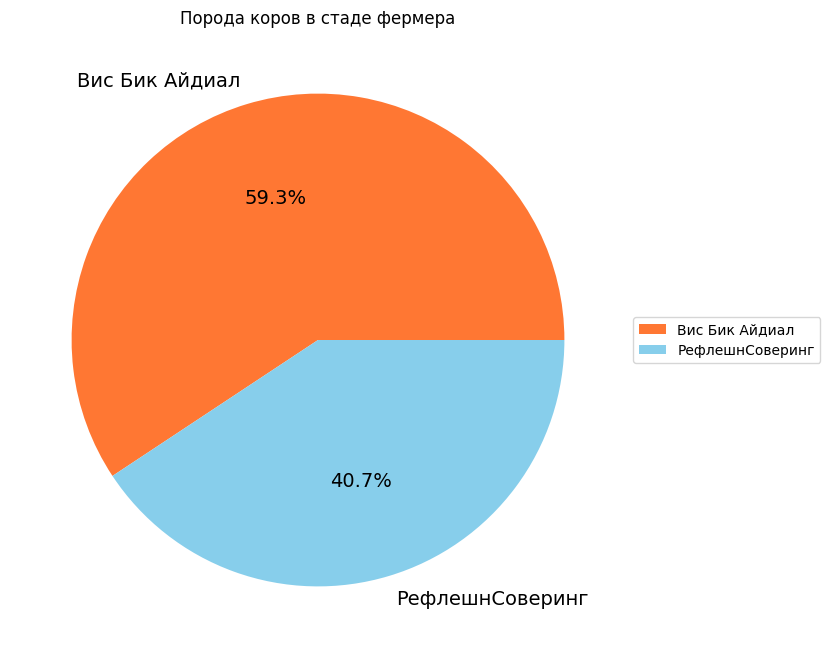

Порода папы коровы в стаде фермера


count  percent
sire_bull_breed                
Вис Бик Айдиал     318    50.56
РефлешнСоверинг    311    49.44

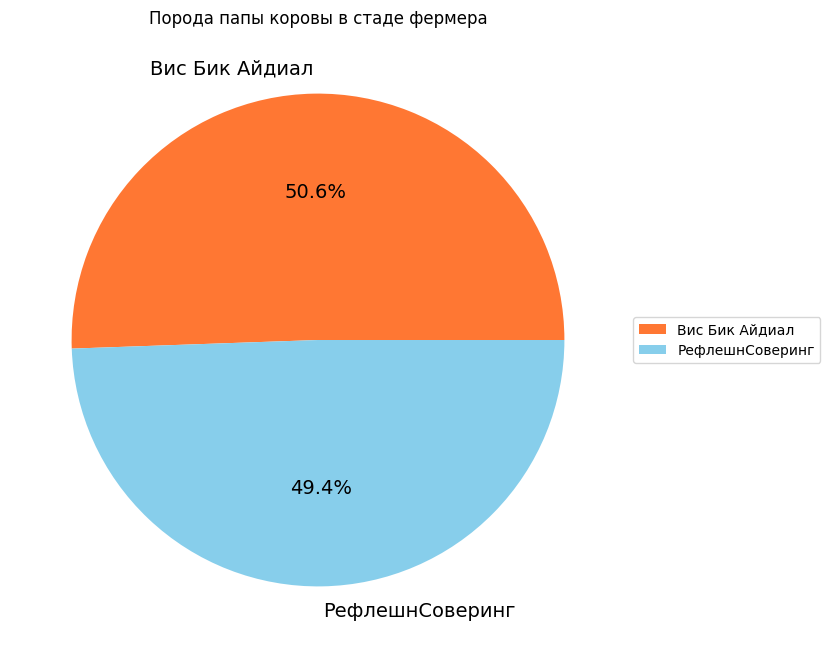

Ландшафт лугов, на которых паслась корова


count  percent
pasture_type                
холмистое       351    55.80
равнинное       278    44.20

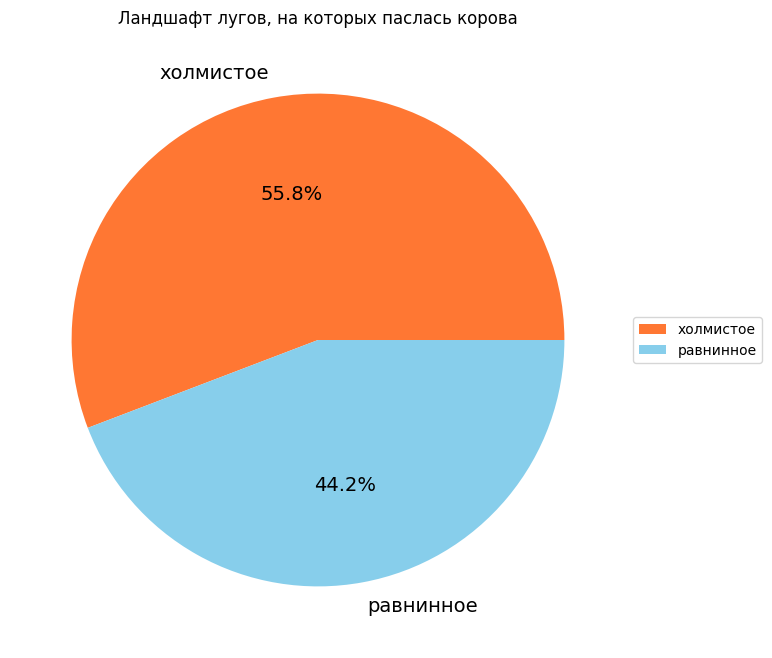

Оценка вкуса молока по личным критериям фермера


count  percent
milk_taste                
вкусно        371    58.98
не вкусно     258    41.02

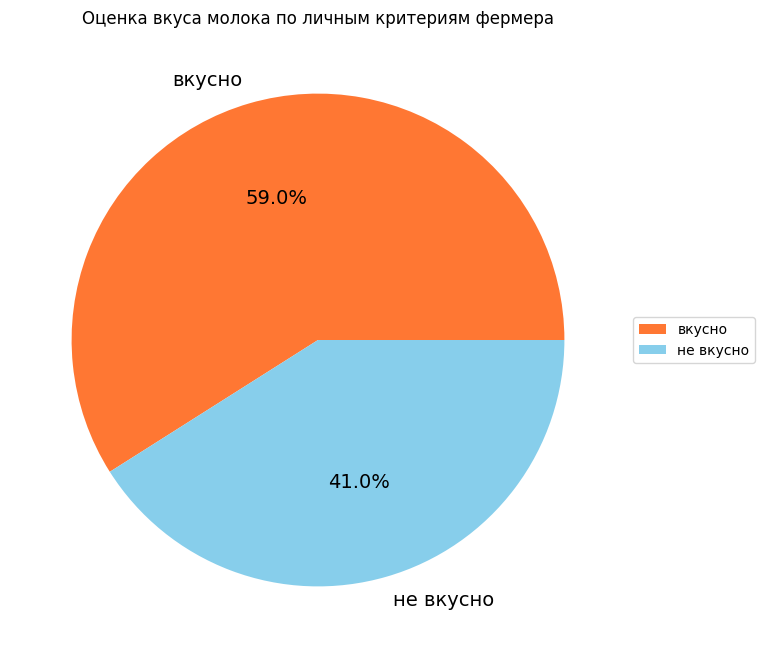

Возраст коровы в стаде фермера


count  percent
age                        
более_2_лет    519    82.51
менее_2_лет    110    17.49

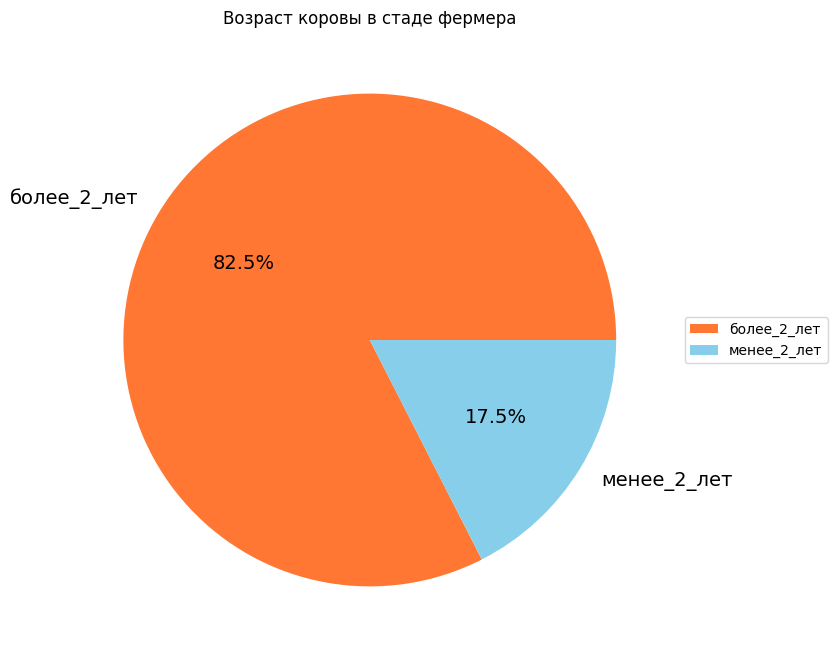

In [325]:
# посмотрим на категориальные показатели для коров фермера
analyze_categorical_data(
    ferma_main, 
    {'breed':'Порода коров в стаде фермера',
     'sire_bull_breed':'Порода папы коровы в стаде фермера',
     'pasture_type': 'Ландшафт лугов, на которых паслась корова',
     'milk_taste': 'Оценка вкуса молока по личным критериям фермера',
     'age': 'Возраст коровы в стаде фермера'     
    },
    'id')

Имена пап коров из стада фермеров


count  percent
sire_name                
Барин        240    38.16
Буйный       215    34.18
Соловчик     110    17.49
Геркулес      64    10.17

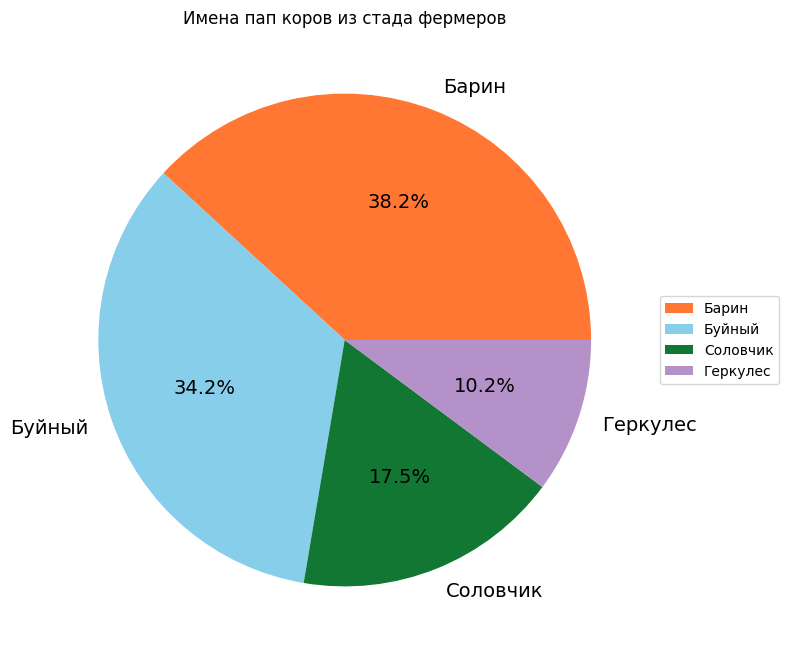

In [326]:
analyze_categorical_data(ferma_dad, {'sire_name':'Имена пап коров из стада фермеров'}, 'id')

In [327]:
# посмотрим на распределение коров по возрасту и породе
pivot_table = pd.pivot_table(ferma_main, 
                             index='age', 
                             columns='breed', 
                             values='id', 
                             aggfunc='count', 
                             margins=True, 
                             margins_name='Всего'
                            )
pivot_table

breed        Вис Бик Айдиал  РефлешнСоверинг  Всего
age                                                
более_2_лет             301              218    519
менее_2_лет              72               38    110
Всего                   373              256    629

In [328]:
# посмотрим на распределение коров по типу пастбища и породе
ferma_main.groupby(['breed','pasture_type']).agg({'id': 'count'})

id
breed           pasture_type     
Вис Бик Айдиал  равнинное     187
                холмистое     186
РефлешнСоверинг равнинное      91
                холмистое     165

__В стаде фермера__ 629 коров двух пород: Вис Бик Айдиал (59.3%) и РефлешнСоверинг(40.7%).  Коров в возрасте более 2 лет значительно больше (82.5%). В каждой возрастной категории преобладают коровы породы породы Вис Бик Айдиал. Также эта порода незначительно преобладает среди пап-быков (50.56%). Среди пап коров выделяются Барин(38.16%) и Буйный(34.18%), за ними идут 
Соловчик(17.49%) и Геркулес(10.17%). 

На холмистых пастбищах паслись 55.8% коров, на равнинных - 44.2%. Коровы породы РефлешнСоверинг чаще паслись на холмистых пастбищах, чем на равнинных - 165 против 91, для коров Вис Бик Айдиал не выявлено преобладающего типа пастбища.

По личным критериям фермера он находит вкусным молоко только 59% коров.

Порода коров "ЭкоФермы"


count  percent
breed                          
РефлешнСоверинг     11    55.00
Вис Бик Айдиал       9    45.00

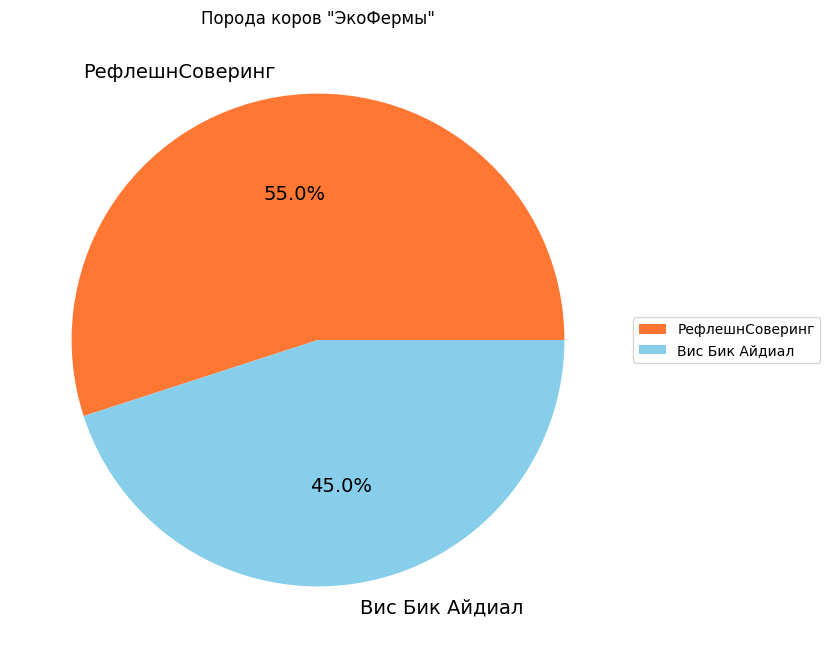

Порода папы коровы "ЭкоФермы"


count  percent
sire_bull_breed                
РефлешнСоверинг     12    60.00
Вис Бик Айдиал       8    40.00

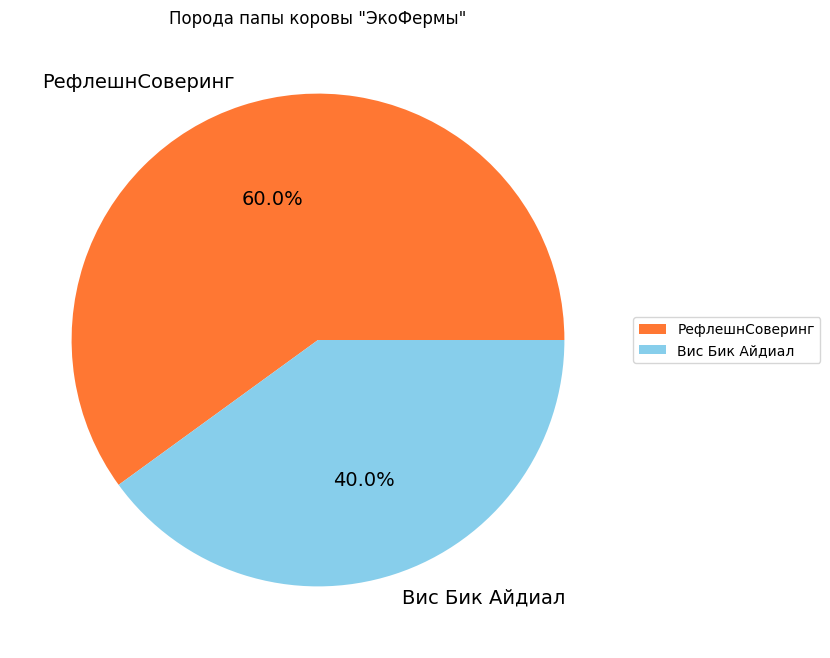

Имена пап коров "ЭкоФермы"


count  percent
sire_name                
Буйный         8    40.00
Геркулес       6    30.00
Барин          4    20.00
Соловчик       2    10.00

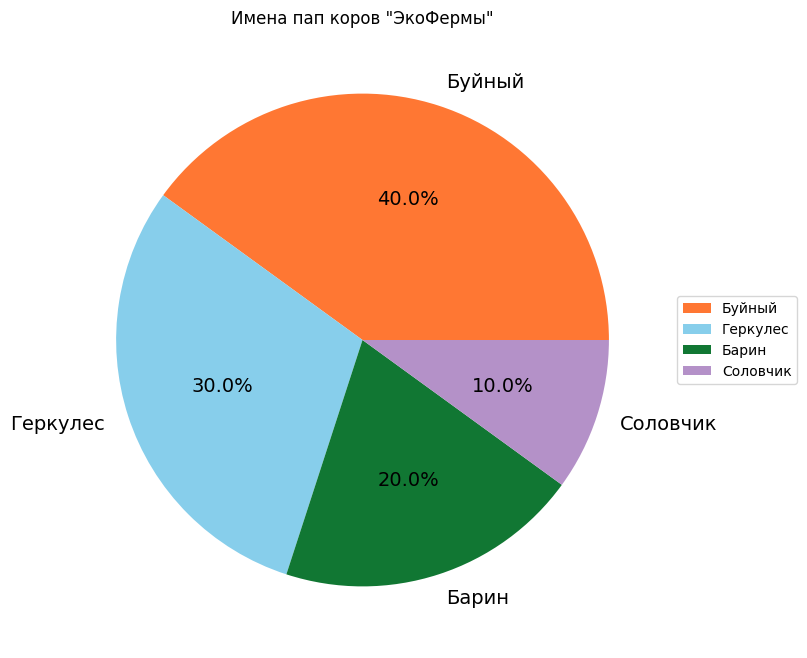

Ландшафт лугов, на которых паслась корова "ЭкоФермы"


count  percent
pasture_type                
равнинное        11    55.00
холмистое         9    45.00

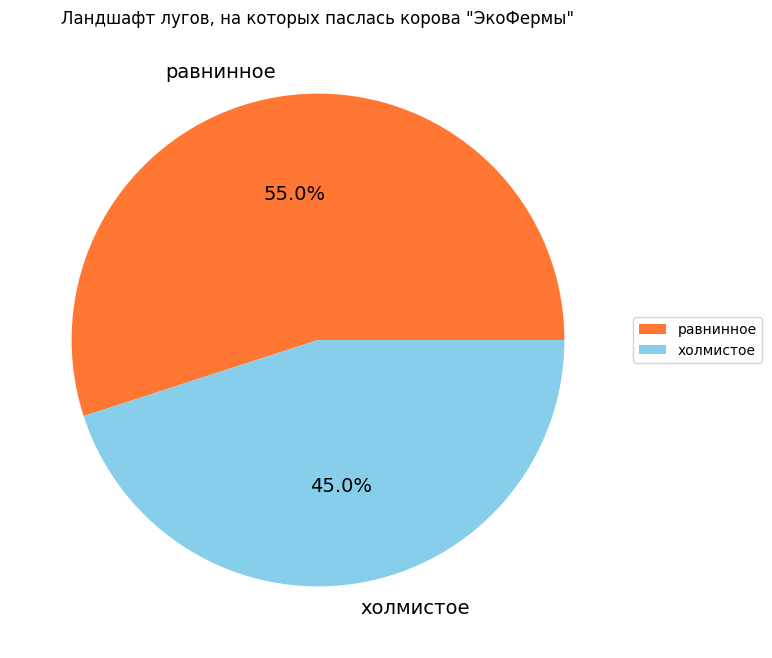

Возраст коровы "ЭкоФермы"


count  percent
age                        
более_2_лет     15    75.00
менее_2_лет      5    25.00

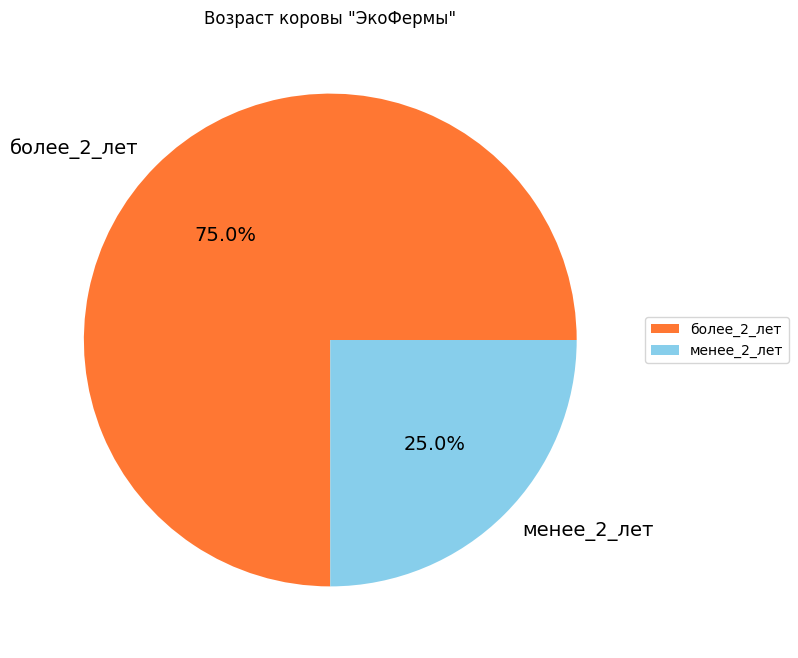

In [329]:
# посмотрим на категориальные показатели для коров "ЭкоФермы"
analyze_categorical_data(
    cow_buy, 
    {'breed':'Порода коров "ЭкоФермы"',
     'sire_bull_breed':'Порода папы коровы "ЭкоФермы"',
     'sire_name':'Имена пап коров "ЭкоФермы"',
     'pasture_type': 'Ландшафт лугов, на которых паслась корова "ЭкоФермы"',
     'age': 'Возраст коровы "ЭкоФермы"'     
    },
    'fat_percent')

In [330]:
# посмотрим на распределение коров по возрасту и породе
pivot_table = pd.pivot_table(cow_buy, 
                             index='age', 
                             columns='breed', 
                             values='fat_percent', 
                             aggfunc='count', 
                             margins=True, 
                             margins_name='Всего'
                            )
pivot_table

breed        Вис Бик Айдиал  РефлешнСоверинг  Всего
age                                                
более_2_лет               7                8     15
менее_2_лет               2                3      5
Всего                     9               11     20

__К покупке у 'ЭкоФермы'__ фермер рассматривает 20 коров, из них 9 - породы Вис Бик Айдиал	и 11 - РефлешнСоверинг. Возраст 15 коров составляет более 2 лет. Среди пап коров преобладает порода РефлешнСоверинг(60%). Среди пап коров выделяется  Буйный(40%) и Геркулес(30%), за ними идут Барин(20%) и Соловчик(10%).

45% предложенных коров паслись на холмистых пастбищах, 55% - на равнинных.

Теперь рассмотрим количественные признаки.

In [331]:
def analyze_numerical_data(data, column, title, bins_number=100):
    """
    Функция помогает при проведении статистического анализа количественных признаков.

    Принимает датасет, столбец для анализа и значение заголовка для вывода графика.
    Может принимать bins для построения графика.

    Выводит для колонки:
    - описание данных
    - гистограмму с отмеченным средним значением и медианой
    - диаграмму размаха
    """
     
    # получим описание данных
    print('\033[1m' + title + '\033[0m')
    display(data[column].describe())
    
    median = data[column].median()
    mean = data[column].mean()
        
    # построим гистограмму
    fig, ax = plt.subplots(figsize = (15,8))
    ax = data[column].plot.hist(bins=bins_number, color='skyblue', grid=True)
    ax.set_xlabel(title, fontsize = 14)
    ax.set_ylabel('Частота', fontsize = 14)
    ax.set_title(title, fontsize = 18)
    plt.axvline(median, color='red', linestyle='dashed', linewidth=1.5, label=f'Медиана: {median:.2f}')
    plt.axvline(mean, color='green', linestyle='dashed', linewidth=1.5, label=f'Среднее: {mean:.2f}')
    
    plt.legend()
    plt.show() 
        
    # построим диаграмму размаха
    fig, ax = plt.subplots(figsize = (17,2))
    data[[column]].boxplot(vert=False, ax=ax)
    plt.title(f'Диаграмма размаха для признака "{title}"', fontsize=18)
    plt.show()

Изучим количественные признаки для датасета `ferma_main`.

Масса молока, которую корова даёт в год, кг


count      629.00
mean     6,188.75
std      1,644.80
min      5,204.00
25%      5,751.00
50%      6,133.00
75%      6,501.00
max     45,616.00
Name: milk_yield, dtype: float64

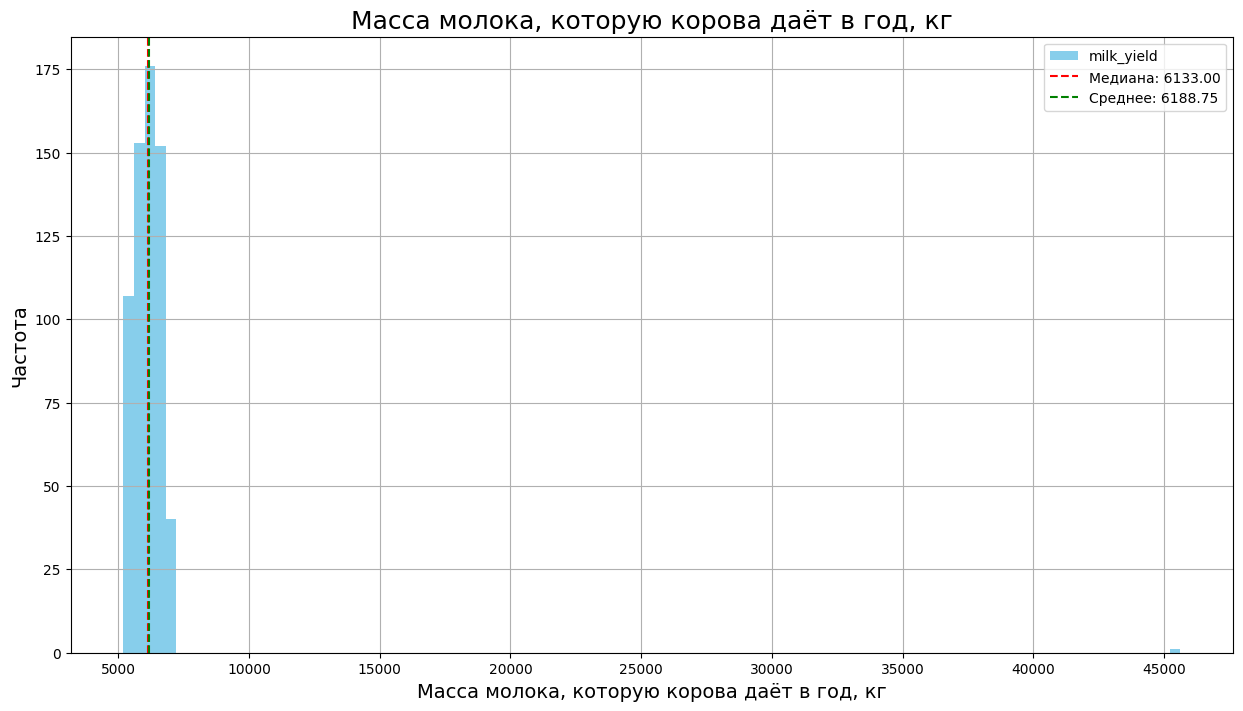

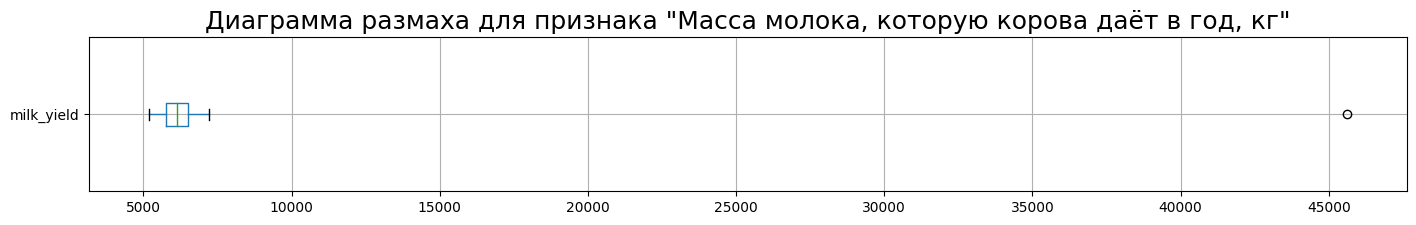

In [332]:
analyze_numerical_data(ferma_main,'milk_yield', 'Масса молока, которую корова даёт в год, кг')

Максимальное значение 45,616.00 - явно выброс. Сложно предположить истинное значение этого параметра, поэтому удалим строку, содержащую данное значение, и посмотрим на обновленное описание данных.

In [333]:
# получим значение выброса
fliers = boxplot_stats(ferma_main['milk_yield'])[0]['fliers']

ferma_main = ferma_main.drop(ferma_main[ferma_main['milk_yield'].isin(fliers)].index)

In [334]:
# контролируем изменение размерности
ferma_main.shape[0]

628

Масса молока, которую корова даёт в год, кг


count     628.00
mean    6,125.97
std       475.86
min     5,204.00
25%     5,749.75
50%     6,132.50
75%     6,501.00
max     7,222.00
Name: milk_yield, dtype: float64

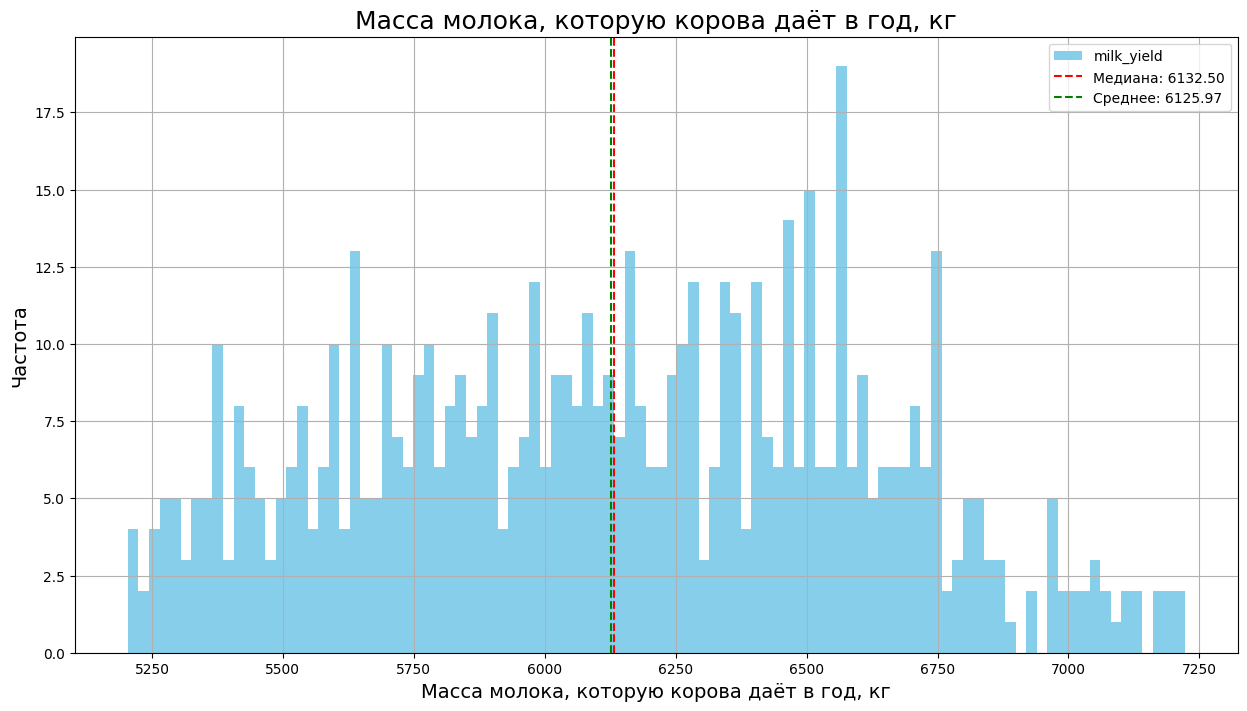

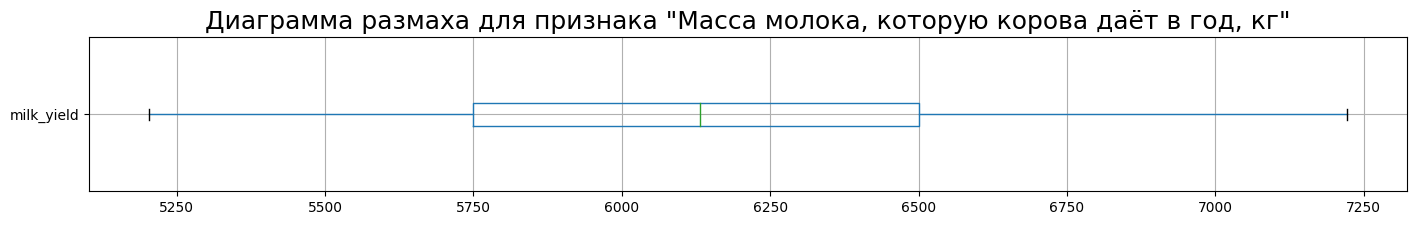

In [335]:
analyze_numerical_data(ferma_main,'milk_yield', 'Масса молока, которую корова даёт в год, кг')

__В стаде фермера__ _среднее значение массы молока_, которую корова даёт в год, близко к медианному: 6,125.97 и 6,132.50 кг соответственно, стандартное отклонение - 475.86 кг. Минимальное значение - 5,204.00 кг, максимальное - 7,222.00 кг. Границы межквартильного размаха - 5,749.75 и 6,501.00 кг.

ЭКЕ (Энергетическая кормовая единица)


count   628.00
mean     14.55
std       1.30
min      10.90
25%      13.50
50%      14.70
75%      15.60
max      16.80
Name: nutritional_energy_unit, dtype: float64

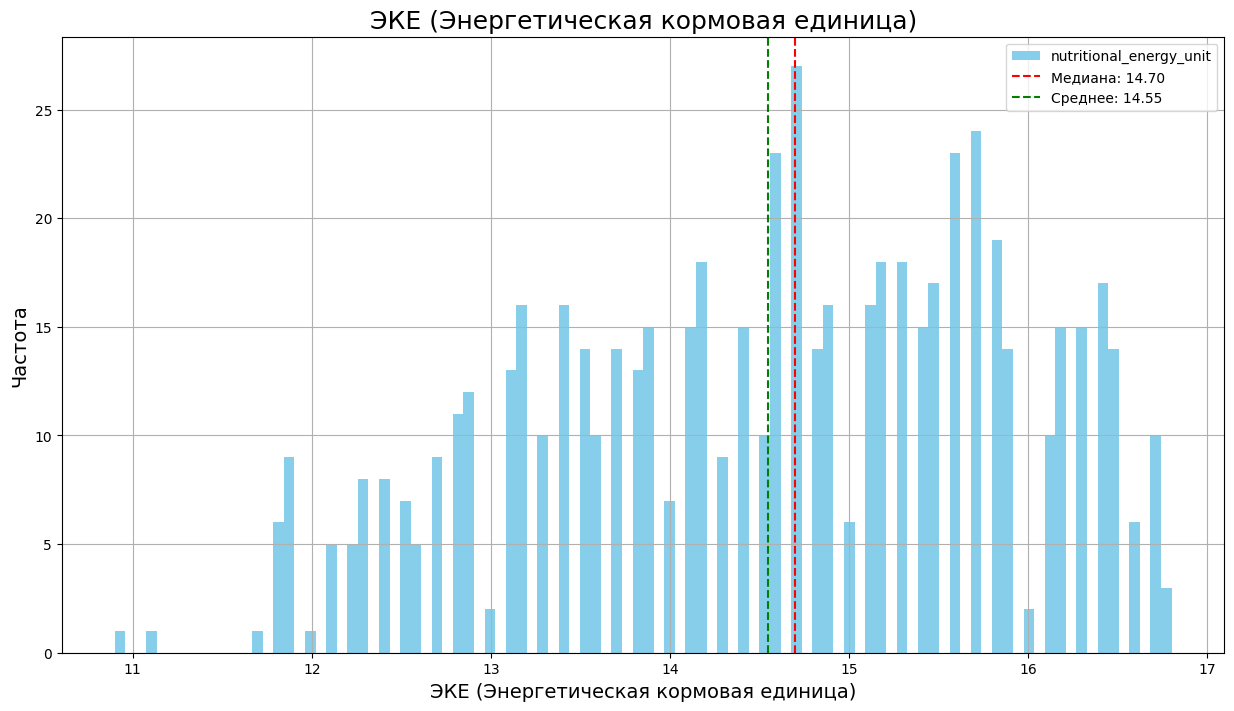

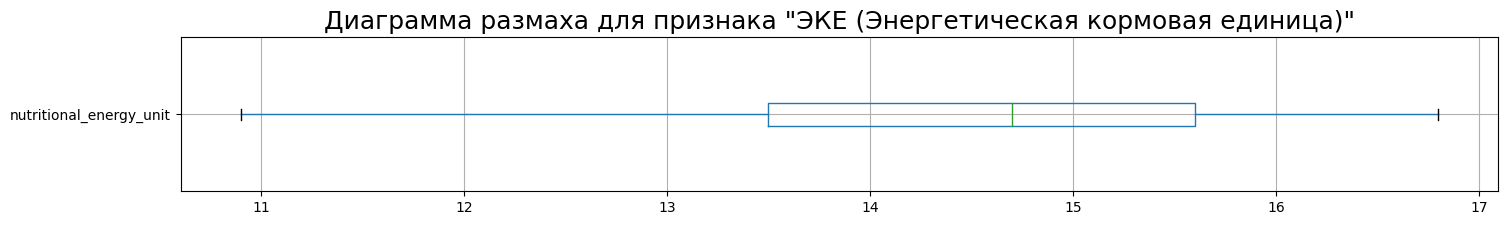

In [336]:
analyze_numerical_data(ferma_main,'nutritional_energy_unit', 'ЭКЕ (Энергетическая кормовая единица)')

Значения ЭКЕ лежат в диапазоне от 10.9 до 16.8. Границы межквартильного размаха: 13.5 и 15.6. Среднее значение близко к медианному - 14.55 и 14.70 соответственно, стандартное отклонение - 1.3. Выбросов нет.

Содержание сырого протеина в корме, г


count     628.00
mean    1,923.76
std       182.83
min     1,660.00
25%     1,771.75
50%     1,888.00
75%     2,062.25
max     2,349.00
Name: crude_protein, dtype: float64

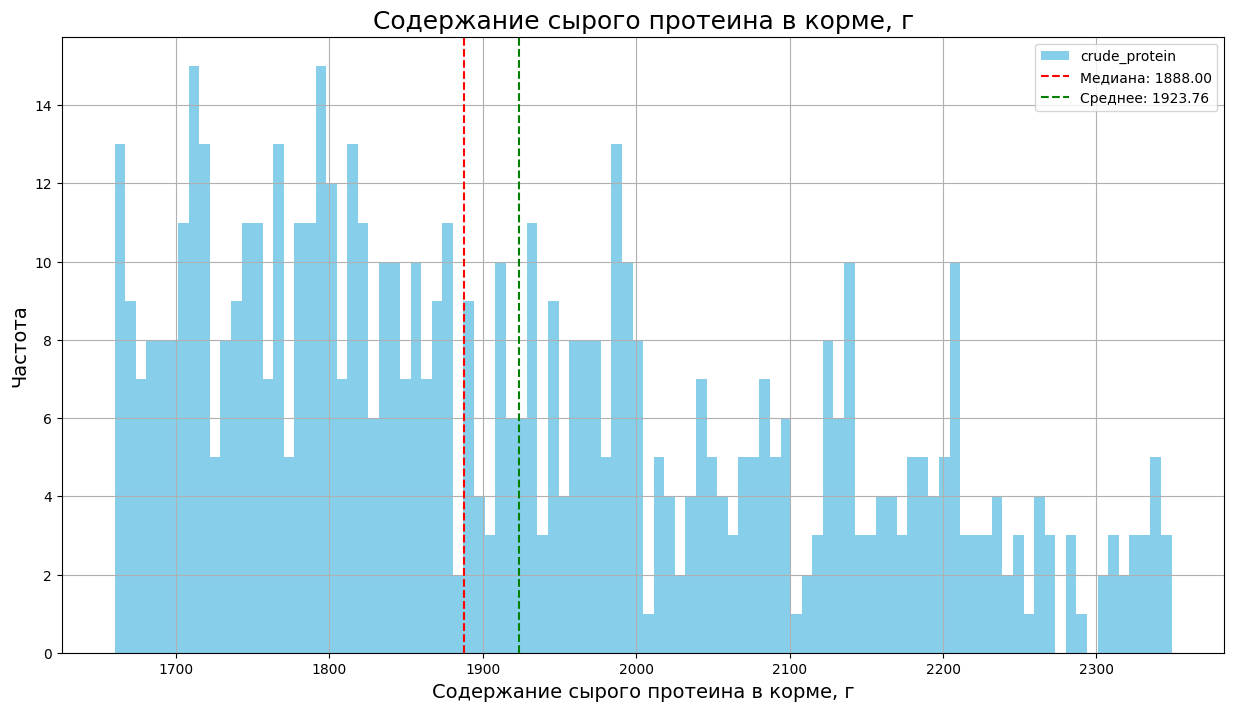

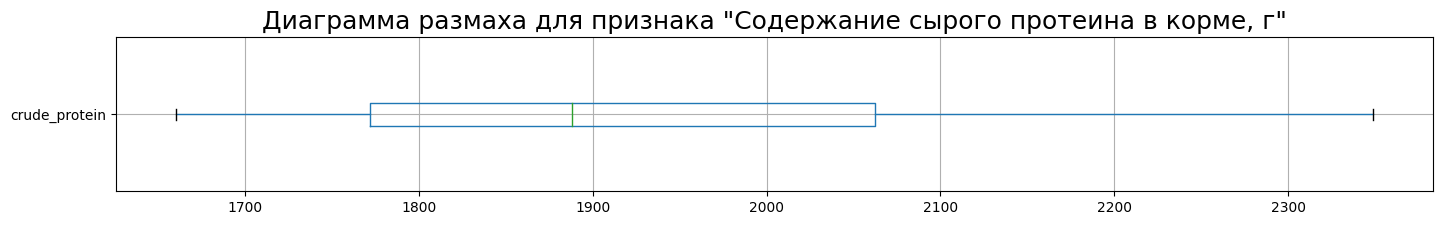

In [337]:
analyze_numerical_data(ferma_main,'crude_protein', 'Содержание сырого протеина в корме, г')

Содержание сырого протеина в корме находится в пределах от 1660 г до 2349 г. Половина значений лежит в диапазоне от 1771.75 до 2062.25 г. Среднее значение превышает медианное: 1923.76 г и 1888 г, стандартное отклонение составляет 182.83 г. Выбросов нет.

Отношение сахара к протеину в корме коровы


count   628.00
mean      0.91
std       0.03
min       0.84
25%       0.89
50%       0.93
75%       0.94
max       0.96
Name: sugar_protein_ratio, dtype: float64

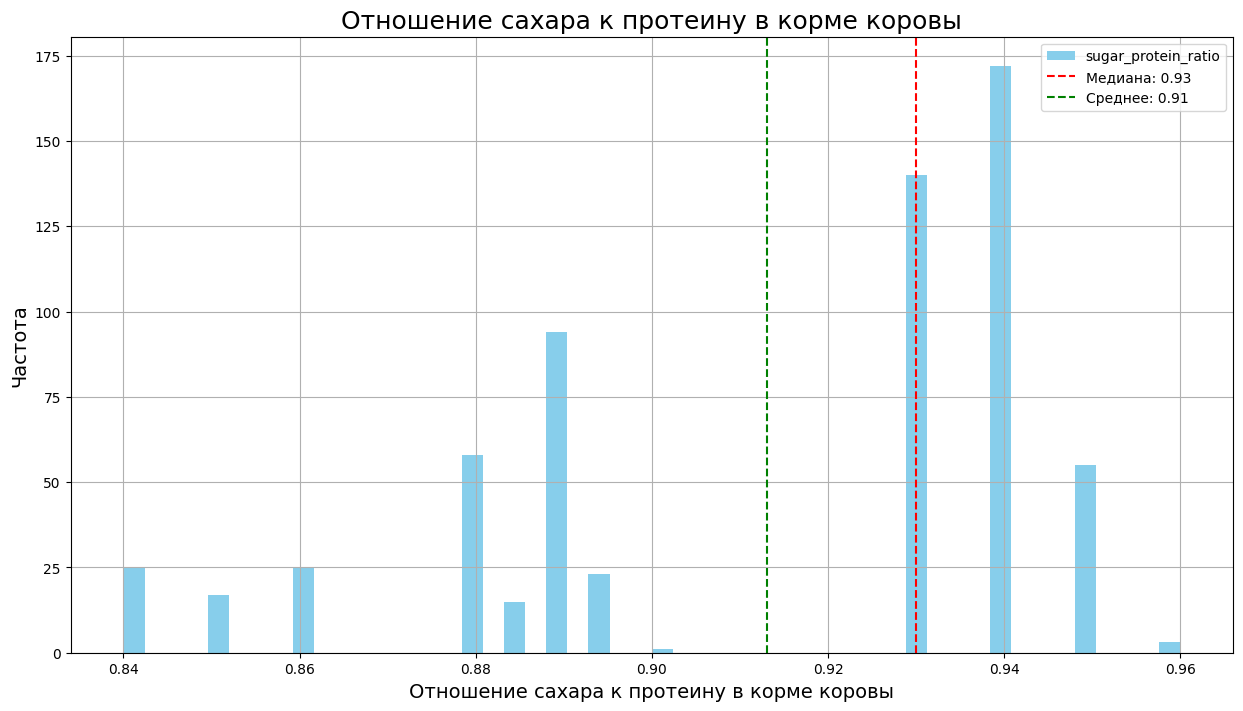

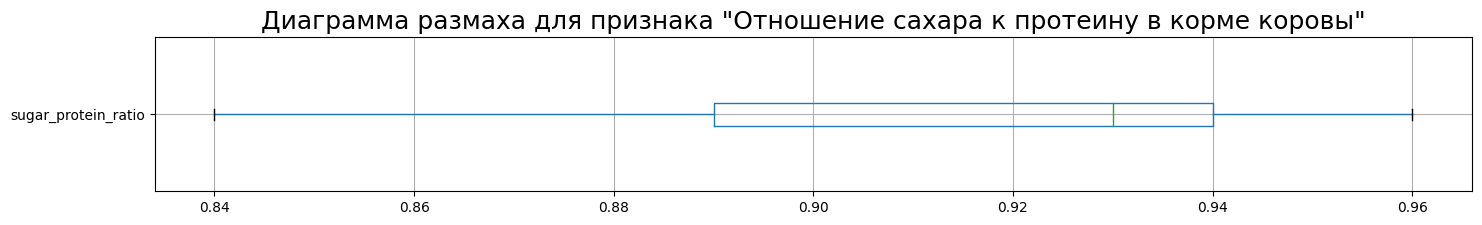

In [338]:
analyze_numerical_data(ferma_main,'sugar_protein_ratio', 'Отношение сахара к протеину в корме коровы', 50)

Отношение сахара к протеину в корме находится в пределах от 0.84 до 0.96 г. Границы межквартильного размаха:  0.89 и 0.94. Медианное значение превышает среднее - 0.91 г и 0.93 г, стандартное отклонение составляет 0.03.  Выбросов нет. Распределение скошено влево.

Cодержание жиров в молоке, %


count   628.00
mean      3.60
std       0.17
min       2.99
25%       3.59
50%       3.65
75%       3.72
max       3.75
Name: fat_percent, dtype: float64

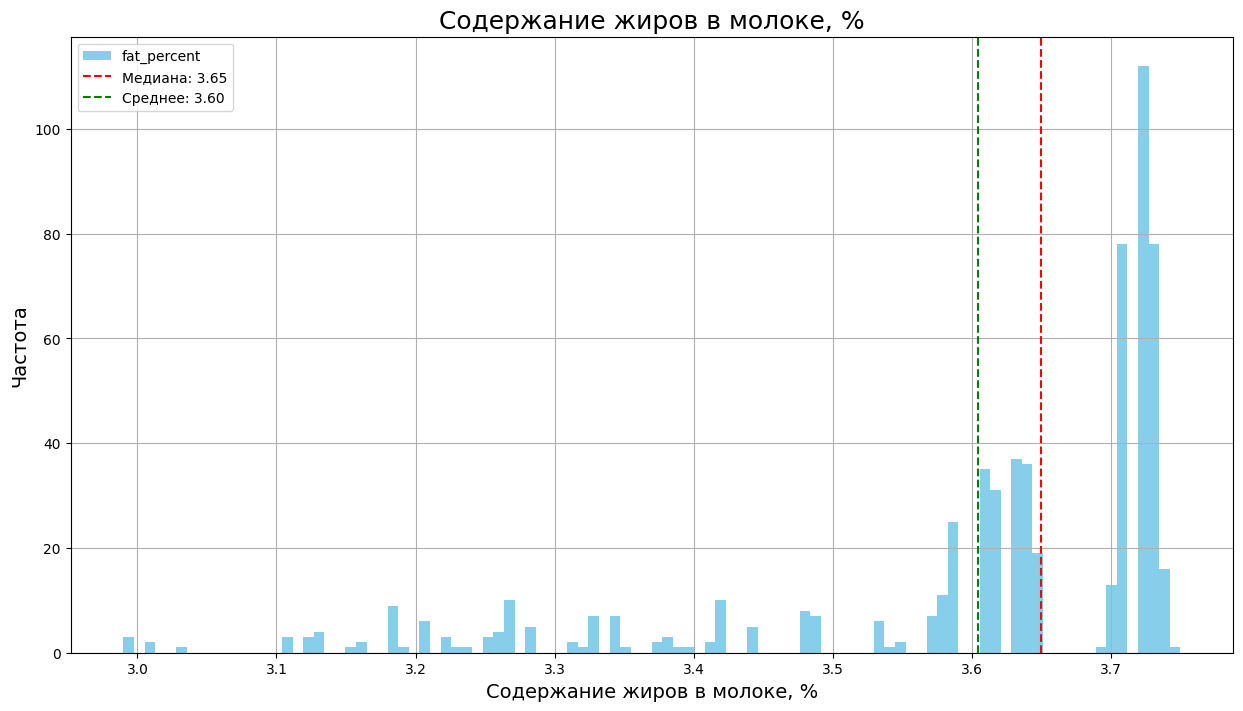

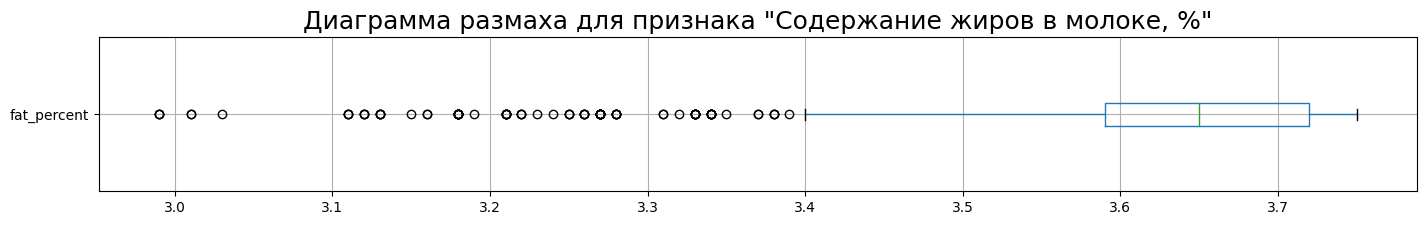

In [339]:
analyze_numerical_data(ferma_main,'fat_percent', 'Cодержание жиров в молоке, %', 100)

Значения процентного содержания жиров ниже 3.4% определены как аномальные. Вместе с тем, для показателя жирности это вполне обычные значения, просто в нашем датасете таких наблюдений не много. Не будем их удалять.  

Содержание жиров в молоке колеблется от 2.99% до 3.75%. Границы межквартильного размаха: 3.59% и 3.72%. Среднее значение меньше медианного - 3.60% и 3.65% соответсвенно, стандартное отклонение составляет 0.17. Значения ниже 3.4% определены как нетипичные для нашего датасета. Стоит отметить, что в реальности такой процент жирности не является аномальным.

Cодержание белков в молоке, %


count   628.00
mean      3.08
std       0.00
min       3.07
25%       3.07
50%       3.08
75%       3.08
max       3.08
Name: protein_percent, dtype: float64

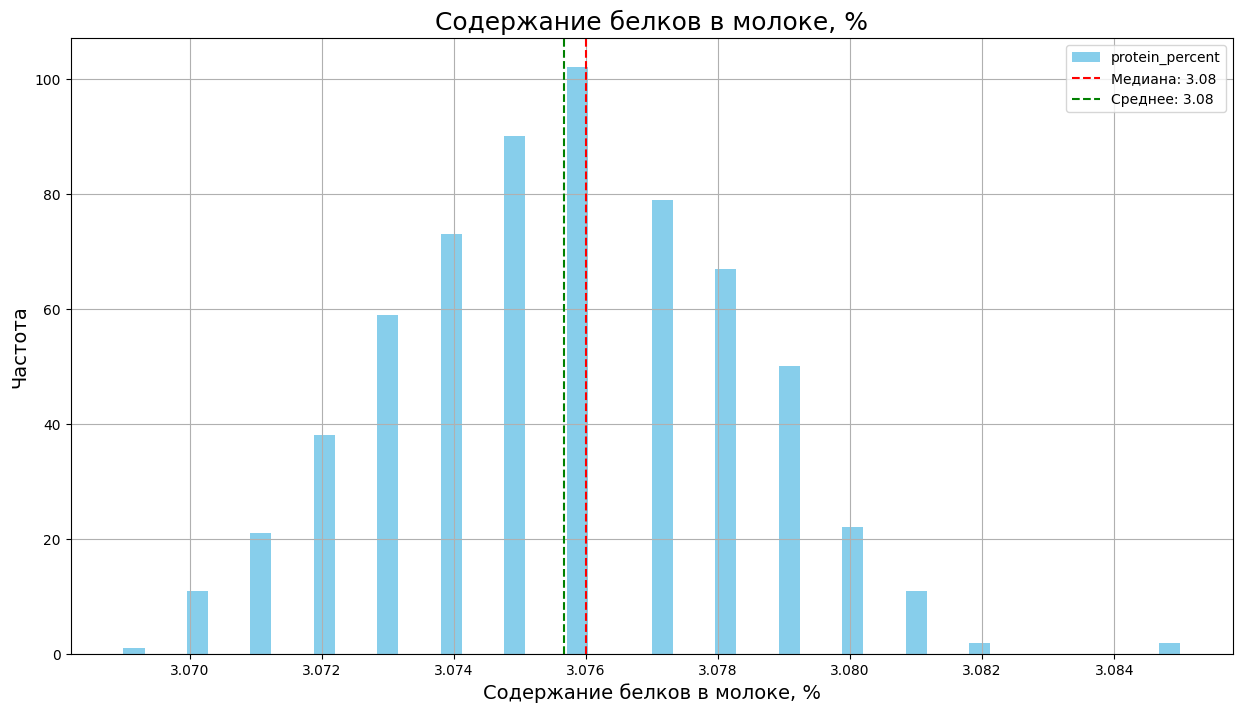

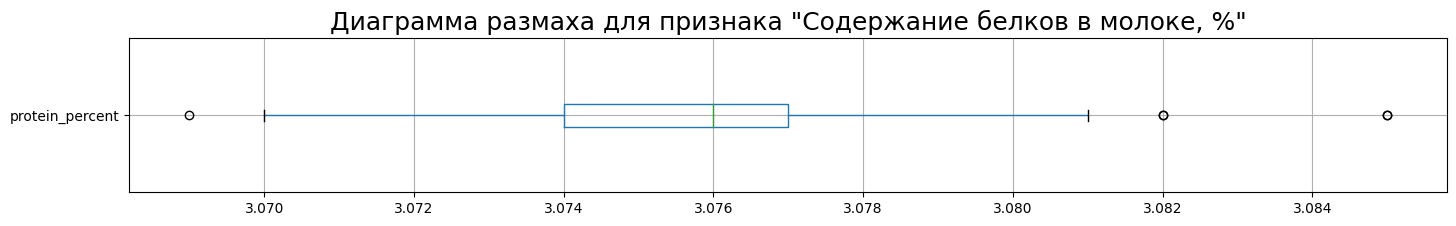

In [340]:
analyze_numerical_data(ferma_main,'protein_percent', 'Cодержание белков в молоке, %', 50)

In [341]:
ferma_main['protein_percent'].min()

3.069

In [342]:
ferma_main['protein_percent'].max()

3.085

Распределение содержания белков в молоке имеет форму колокола, с одним пиком. Среднее значение и медиана практически совпадают, значение составляет 3.08%, стандартное отклонение равно 0, значит данные плотно сгруппированы вокруг среднего и почти одинаковы. Границы межквартильного размаха 3.07% и 3.08%. Наименьшее значение - 3.069%, максимальное - 3.085%. Несколько значений определены как выбросы, однако они довольно близки к остальным, оставим эти наблюдения.

Теперь посмотрим на параметры молока из датасета `cow_buy`, данные "ЭкоФермы".

Cодержание жиров в молоке, %


count   20.00
mean     3.58
std      0.13
min      3.34
25%      3.51
50%      3.59
75%      3.65
max      3.77
Name: fat_percent, dtype: float64

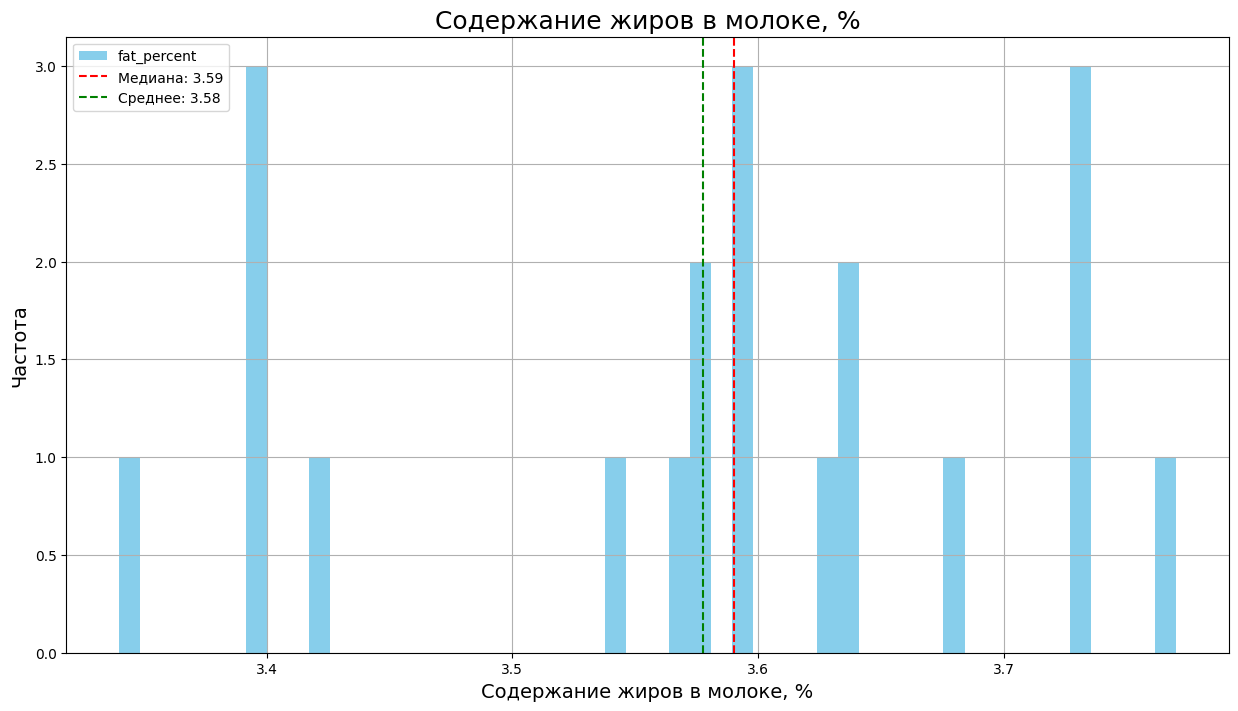

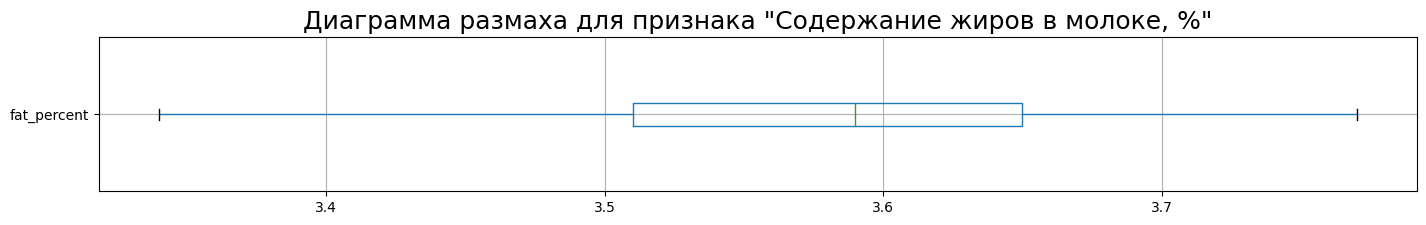

In [343]:
analyze_numerical_data(cow_buy,'fat_percent', 'Cодержание жиров в молоке, %', 50)

Содержание жиров в молоке коров "ЭкоФермы" колеблется от 3.34% до 3.77%. Границы межквартильного размаха: 3.51% и 3.65%. Среднее значение меньше медианного - 3.58% и 3.59% соответственно, стандартное отклонение составляет 0.13. 

Cодержание белков в молоке, %


count   20.00
mean     3.07
std      0.01
min      3.05
25%      3.06
50%      3.07
75%      3.08
max      3.08
Name: protein_percent, dtype: float64

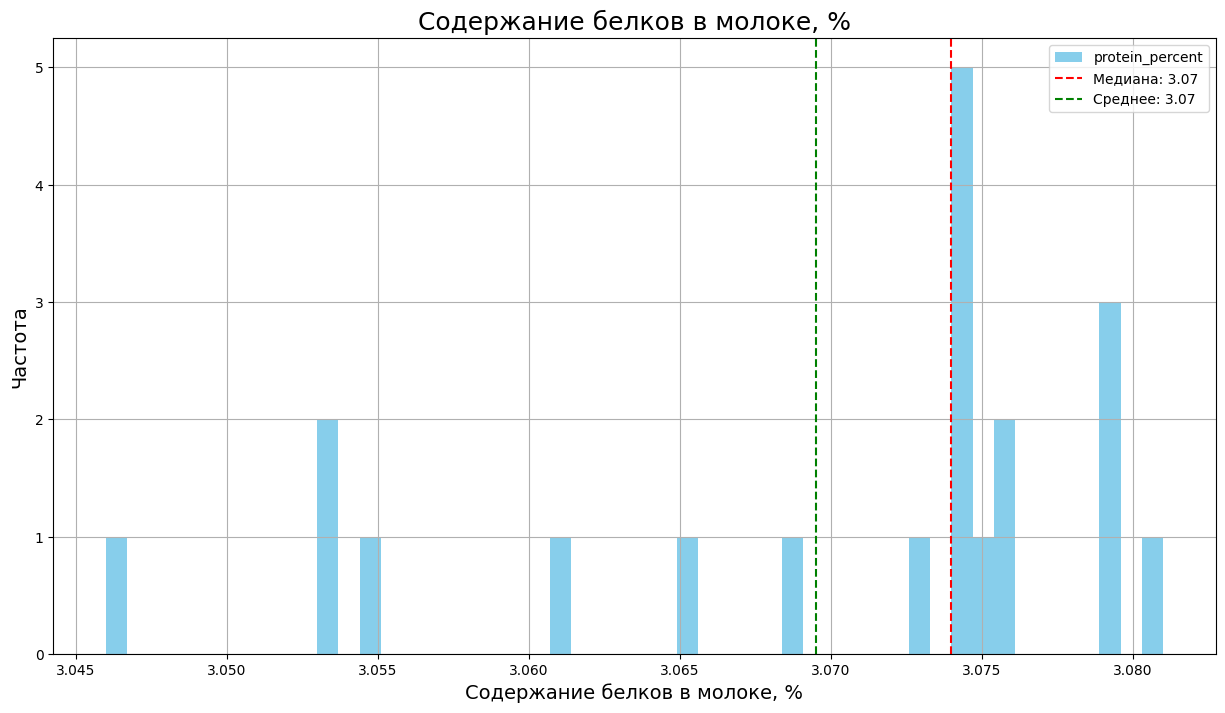

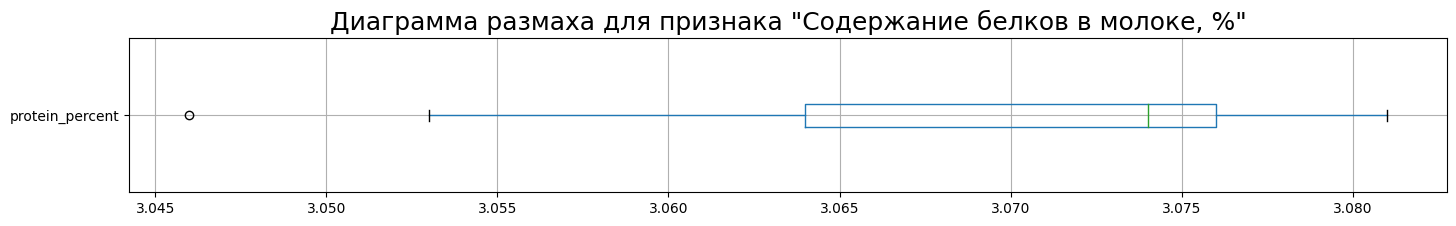

In [344]:
analyze_numerical_data(cow_buy,'protein_percent', 'Cодержание белков в молоке, %', 50)

Процент содержания белков в молоке коров "Экофермы" находится в пределах от 3.05 до 3.08. Среднее значение чуть меньше медианного, отличаются тысячными долями и составляют 3.07%, стандартное отклонение равно 0.01. Границы межквартильного размаха 3.06% и 3.08%. Выбросов нет.

Поищем зависимости между характеристиками.

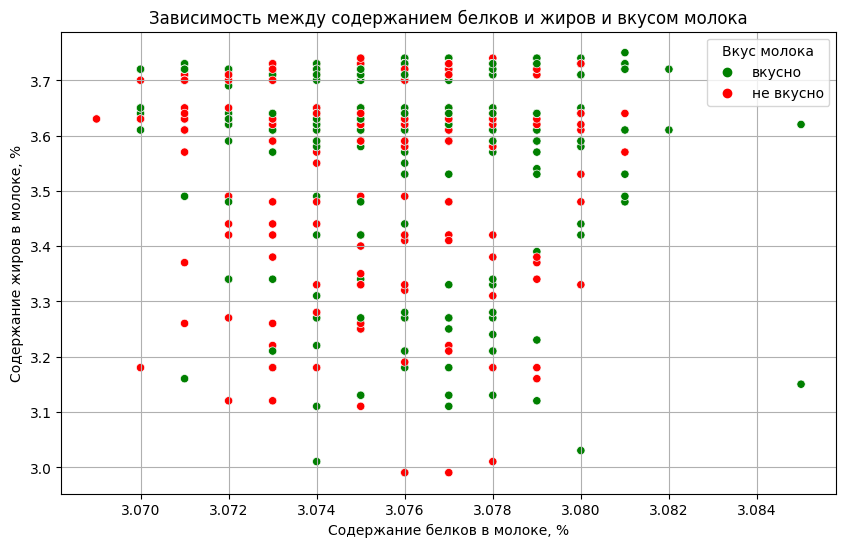

In [345]:
# Попробуем найти зависимость между содержанием белков и жиров и тем, нравится ли фермеру молоко
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='protein_percent', 
    y='fat_percent', 
    hue='milk_taste', # категориальная переменная
    data=ferma_main, 
    palette={'вкусно': 'green', 'не вкусно': 'red'}
)

plt.title('Зависимость между содержанием белков и жиров и вкусом молока')
plt.xlabel('Cодержание белков в молоке, %')
plt.ylabel('Cодержание жиров в молоке, %')
plt.legend(title='Вкус молока')
plt.grid(True)
plt.show()

Явной зависимости отследить не удалось.

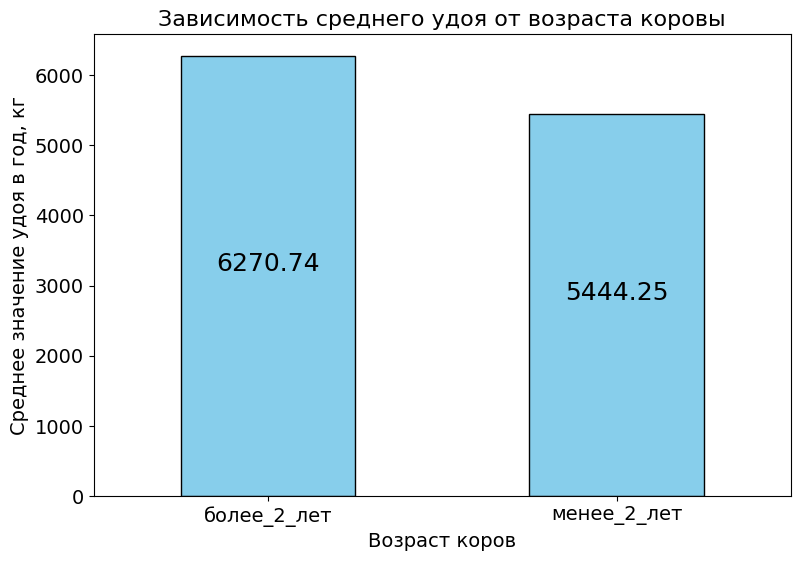

In [346]:
# посмотрим на средний удой в зависимости от возраста коровы

# построим столбчатую диаграмму
ax = ferma_main.groupby('age')['milk_yield'].mean().plot.bar(
    legend=False, figsize = (9,6), rot=0, fontsize=14,  color='skyblue', edgecolor='black')
ax.set_title('Зависимость среднего удоя от возраста коровы', fontsize = 16)
ax.set_xlabel('Возраст коров', fontsize = 14)
ax.set_ylabel('Среднее значение удоя в год, кг', fontsize = 14)

# выводим значения
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2.,
                 p.get_height() / 2.), ha='center', va='bottom', fontsize=18)
    
plt.show()

Видим, что среднее значение удоя молока в год у коров в возрасте более 2 лет больше, чем у коров в возрасте до 2 лет.

In [347]:
# посмотрим на средние и медианные значения параметров в зависимости от породы коровы
group_data = (
    ferma_main
    .groupby('breed')
    .agg(
        {'milk_yield':['mean', 'median'],
         'nutritional_energy_unit':['mean', 'median'],
         'crude_protein':['mean', 'median'],
         'sugar_protein_ratio':['mean', 'median'],
         'fat_percent':['mean', 'median'],
         'protein_percent':['mean', 'median']         
        }
    )
)

group_data.style.highlight_max(axis=0, color='yellow')

О корме коров фермера можно сказать, что средний и медианный показатели сырого протеина и ЭКЕ, средний показатель сахаро-протеинового соотношения больше для коров породы РефлешнСоверинг.

Коровы породы РефлешнСоверинг в среднем дают больше молока в год, содержание белка в их молоке в среднем меньше, чем у Вис Бик Айдиал, а среднее значение процента содержания жиров больше. 

In [348]:
# посмотрим на средние и медианные значения параметров в зависимости от типа пастбища
group_data = (
    ferma_main
    .groupby('pasture_type')
    .agg(
        {'milk_yield':['mean', 'median'],
         'nutritional_energy_unit':['mean', 'median'],
         'crude_protein':['mean', 'median'],
         'sugar_protein_ratio':['mean', 'median'],
         'fat_percent':['mean', 'median'],
         'protein_percent':['mean', 'median']         
        }
    )
)

group_data.style.highlight_max(axis=0, color='yellow')

Средние и медианные значения показателей корма (ЭКЕ, сырой протеин) для коров, которые паслись на холмистых пастбищах, превышают аналогичные значения для коров, которые паслись на равнинных. Медианные значения СПО равны.  Средние и медианные значения удоя и содержания белка в молоке также больше для коров, которые паслись на холмистых пастбищах. Среднее значение жирности молока больше у коров, которые паслись на равнинных пастбищах.

__Промежуточный вывод__:
- определили количественные и категориальные признаки;
- __В стаде фермера__ 629 коров двух пород: Вис Бик Айдиал (59.3%) и РефлешнСоверинг(40.7%).  Коров в возрасте более 2 лет значительно больше (82.5%). В каждой возрастной категории преобладают коровы породы породы Вис Бик Айдиал. Также эта порода незначительно преобладает среди пап-быков (50.56%). Среди пап коров выделяются Барин(38.16%) и Буйный(34.18%), за ними идут Соловчик(17.49%) и Геркулес(10.17%). На холмистых пастбищах паслись 55.8% коров, на равнинных - 44.2%. Коровы породы РефлешнСоверинг чаще паслись на холмистых пастбищах, чем на равнинных - 165 против 91, для коров Вис Бик Айдиал не выявлено преобладающего типа пастбища. По личным критериям фермера он находит вкусным молоко только 59% коров.
- __В стаде фермера__ _среднее значение массы молока_, которую корова даёт в год, близко к медианному: 6,125.97 и 6,132.50 кг соответственно, стандартное отклонение - 475.86 кг. Минимальное значение - 5,204.00 кг, максимальное - 7,222.00 кг. Границы межквартильного размаха - 5,749.75 и 6,501.00 кг. Значения _ЭКЕ_ лежат в диапазоне от 10.9 до 16.8. Границы межквартильного размаха: 13.5 и 15.6. Среднее значение близко к медианному - 14.55 и 14.70 соответственно, стандартное отклонение - 1.3. Выброс 45616 кг удален. Содержание _сырого протеина в корме_ находится в пределах от 1660 г до 2349 г. Половина значений лежит в диапазоне от 1771.75 до 2062.25 г. Среднее значение превышает медианное: 1923.76 г и 1888 г, стандартное отклонение составляет 182.83 г. Выбросов нет. _Отношение сахара к протеину в корме_ находится в пределах от 0.84 до 0.96 г. Границы межквартильного размаха: 0.89 и 0.94. Медианное значение превышает среднее - 0.91 г и 0.93 г, стандартное отклонение составляет 0.03. Выбросов нет. Распределение скошено влево. _Содержание жиров в молоке_ колеблется от 2.99% до 3.75%. Границы межквартильного размаха: 3.59% и 3.72%. Среднее значение меньше медианного - 3.60% и 3.65% соответсвенно, стандартное отклонение составляет 0.17. Значения ниже 3.4% определены как нетипичные для нашего датасета, в реальности такой процент жирности не является аномальным.  Распределение _содержания белков в молоке_ имеет форму колокола, с одним пиком, по форме похоже на нормальное. Среднее значение и медиана совпадают и составляют 3.08%, стандартное отклонение равно 0, значит данные плотно сгруппированы вокруг среднего и почти одинаковы. Границы межквартильного размаха 3.07% и 3.08%. Наименьшее значение - 3.069%, максимальное - 3.085%. Несколько значений определены как выбросы, но мы сохраняем эти наблюдения.
- При обработке выбросов удалили строку датасета 'ferma_main', содержащую удой в 45616 кг за год.
- Среднее значение удоя молока в год у коров фермера в возрасте более 2 лет больше, чем у коров в возрасте до 2 лет.
- О корме коров фермера можно сказать, что средний и медианный показатели сырого протеина и ЭКЕ, средний показатель сахаро-протеинового соотношения больше для коров породы РефлешнСоверинг. Коровы породы РефлешнСоверинг в среднем дают больше молока в год, содержание белка в их молоке в среднем меньше, чем у Вис Бик Айдиал, а среднее значение процента содержания жиров больше.
- Средние и медианные значения показателей корма (ЭКЕ, сырой протеин) для коров, которые паслись на холмистых пастбищах, превышают аналогичные значения для коров, которые паслись на равнинных. Медианные значения СПО равны. Средние и медианные значения удоя и содержания белка в молоке также больше для коров, которые паслись на холмистых пастбищах. Среднее значение жирности молока больше у коров, которые паслись на равнинных пастбищах.
- __К покупке у 'ЭкоФермы'__ фермер рассматривает 20 коров, из них 9 - породы Вис Бик Айдиал	и 11 - РефлешнСоверинг. Возраст 15 коров составляет более 2 лет. Среди пап коров преобладает порода РефлешнСоверинг(60%). Среди пап коров выделяется  Буйный(40%) и Геркулес(30%), за ними идут Барин(20%) и Соловчик(10%). 45% предложенных коров паслись на холмистых пастбищах, 55% - на равнинных. _Содержание жиров в молоке_ коров "ЭкоФермы" колеблется от 3.34% до 3.77%. Границы межквартильного размаха: 3.51% и 3.65%. Среднее значение меньше медианного - 3.58% и 3.59% соответственно, стандартное отклонение составляет 0.13. _Процент содержания белков в молоке_ коров "Экофермы" находится в пределах от 3.05 до 3.08. Среднее значение чуть меньше медианного, отличаются тысячными долями и составляют 3.07%, стандартное отклонение равно 0.01. Границы межквартильного размаха 3.06% и 3.08%. Выбросов нет.
- Для улучшения данных необходимо будет провести масштабирование, т.к. признаки имеют разные диапазоны значений. Также необходимо будет кодировать категориальные признаки.

## Корреляционный анализ

Изучим взаимосвязь между признаками. Для этого рассчитаем коэффициенты корреляции Фи между признаками для `ferma_main`.

interval columns not set, guessing: ['id', 'milk_yield', 'nutritional_energy_unit', 'crude_protein', 'sugar_protein_ratio', 'fat_percent', 'protein_percent']


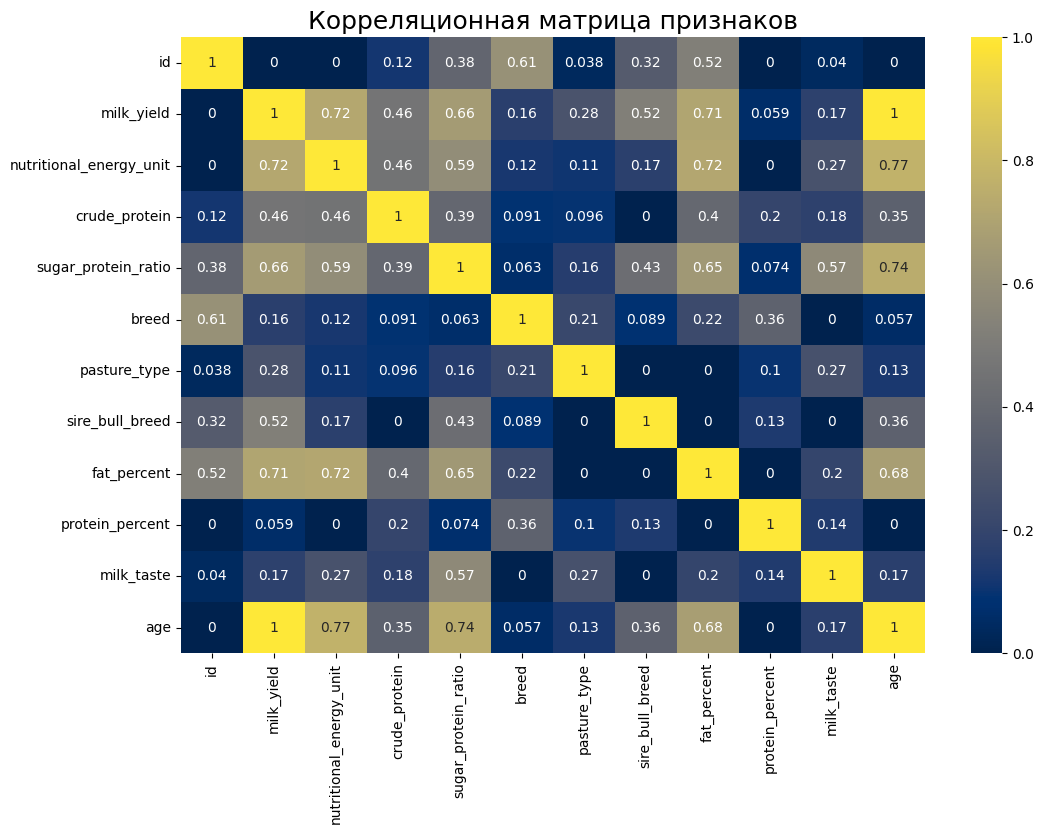

In [349]:
phik_matrix  = ferma_main.phik_matrix()

plt.figure(figsize=(12, 8))
plt.title('Корреляционная матрица признаков', fontsize=18)
sns.heatmap(phik_matrix, annot=True, cmap='cividis');

Наши целевые признаки - это milk_yield и milk_taste. Наблюдается:

- очень сильная взаимосвязь:
    - milk_yield и age (1);
- сильная взаимосвязь: 
    - milk_yield и nutritional_energy_unit (0.72), с повышением питательности корма коровы наблюдаются более высокие удои молока;
    - milk_yield и fat_percent (0.71), с ростом удоев наблюдается рост жирности;
    
- связь средней силы: 
   - milk_yield и sugar_protein_ratio (0.66), с увеличением отношения сахара к протеину в корме коровы наблюдается рост удоев молока; 
   - milk_yield и sire_bull_breed (0.52);
   - milk_taste и sugar_protein_ratio (0.57);
    
- умеренная связь: 
    - milk_yield и crude_protein (0.46);
    
- слабая взаимосвязь:
    - milk_yield и breed (0.16);
    - milk_yield и pasture_type (0.28);
    - milk_taste и nutritional_energy_unit (0.27);
    - milk_taste и crude_protein (0.18);
    - milk_taste и pasture_type (0.27);
    - milk_taste и fat_percent (0.2);
    - milk_taste и protein_percent (0.14);
    - milk_taste и age (0.17);
    
- отсутсвует связь:
    - milk_yield и protein_percent (0.059);
    - milk_yield и id (0), id - это независимый уникальный идентификатор без связи с характеристиками молока;
    - milk_taste и id (0.04);
    - milk_taste и breed (0);
    - milk_taste и sire_bull_breed (0).
    
 Мультиколлинеарности между входными признаками нет.

Построим диаграммы рассеяния для признака milk_yield и всех количественных признаков с учётом значения категориальных признаков.

In [350]:
def plot_scatter(data, numerical_feature, categorical_feature, x_label, categorical_feature_name, numerical_feature_name):
    """
    Строит диаграмму рассеяния для признака milk_yield (удой молока) и заданного количественного признака,
    учитывая категориальный признак.

    Принимает данные для построения графика, название количественного признака и подпись к оси х,
    название категориального признака и подпись для отображения легенды
    """
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x=numerical_feature,
        y='milk_yield',
        hue=categorical_feature,
        palette='viridis',
        data=data,
        alpha=0.6
    )
    plt.title(
        f'Диаграмма рассеяния для признаков "Удой, кг" и "{numerical_feature_name}" по признаку "{categorical_feature_name}"')
    plt.xlabel(x_label)
    plt.ylabel('Удой, кг')
    plt.legend(title=categorical_feature_name)
    plt.show()

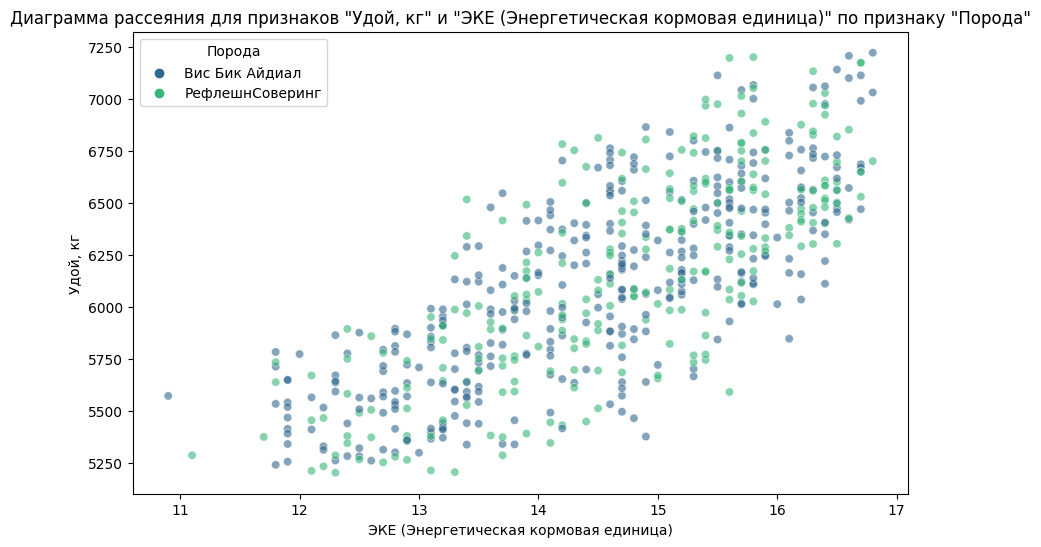

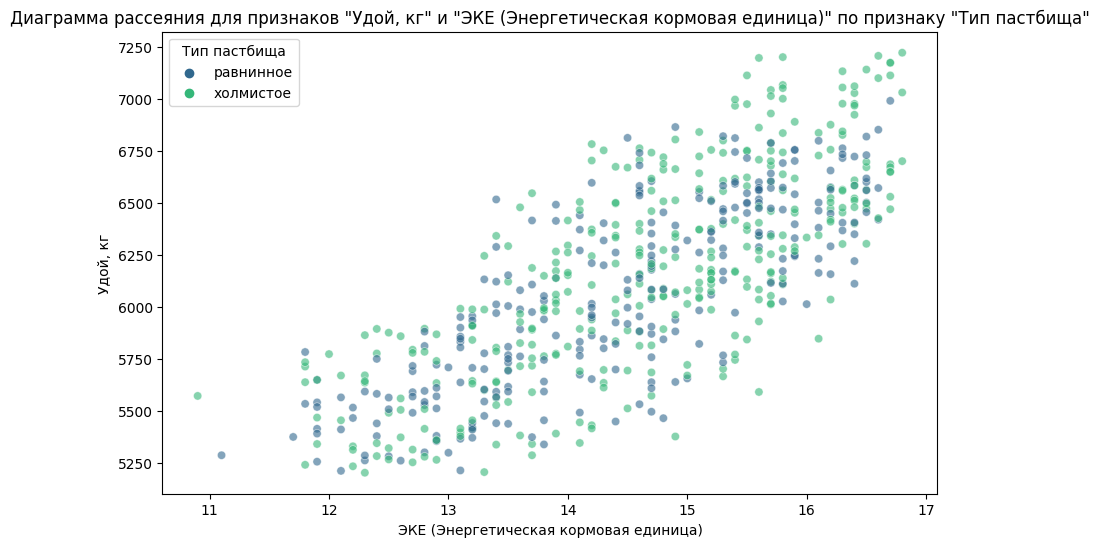

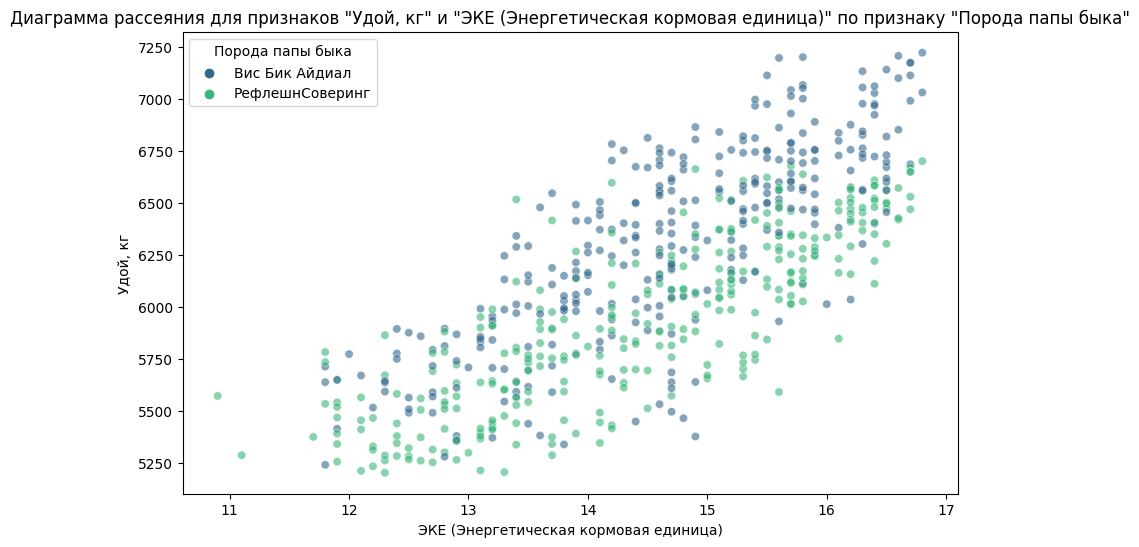

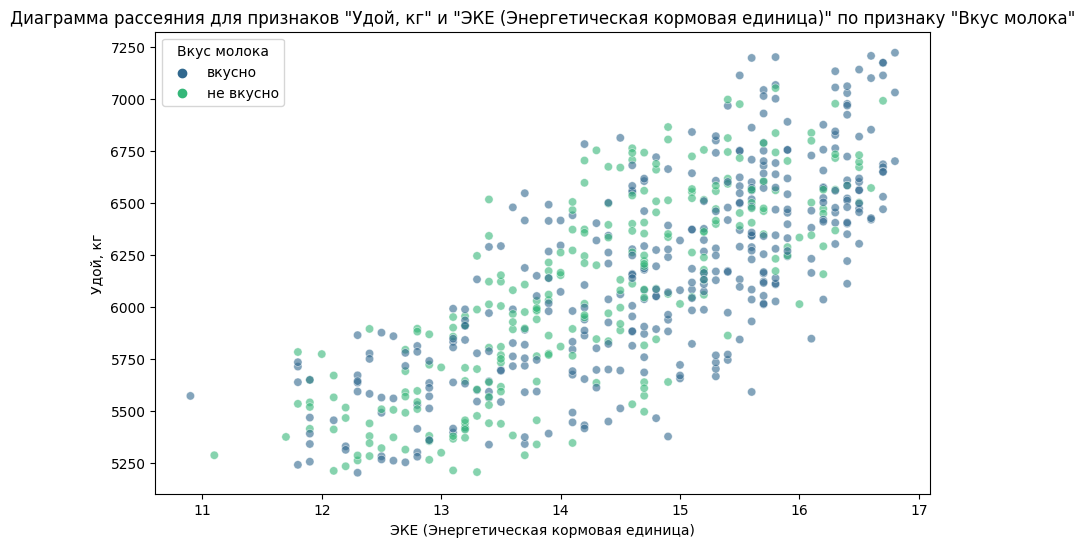

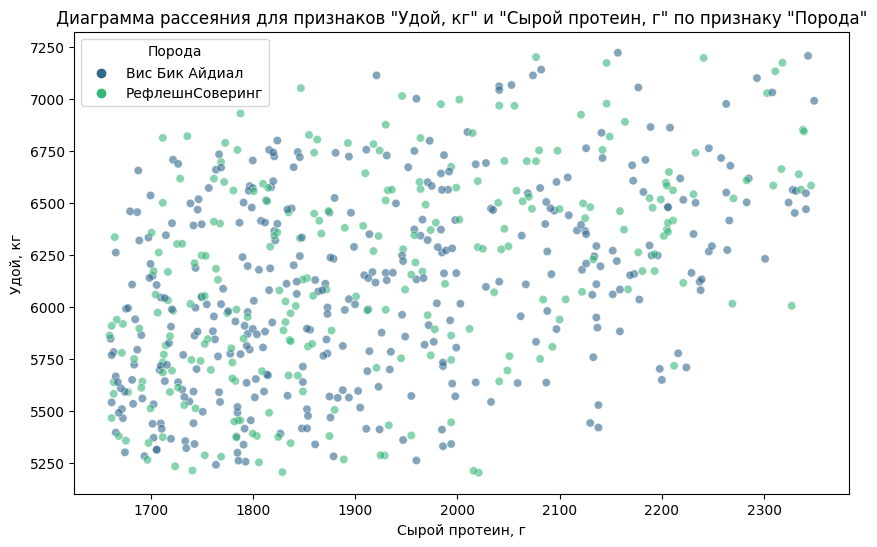

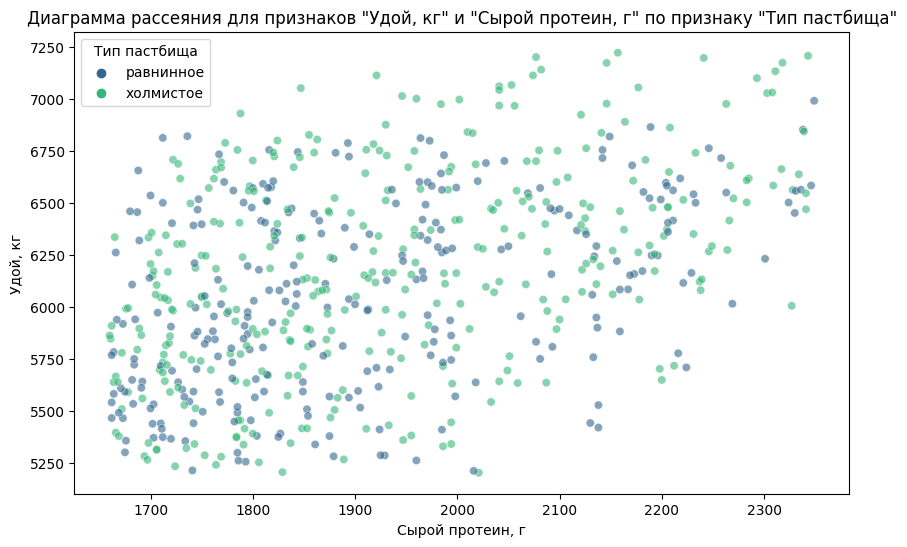

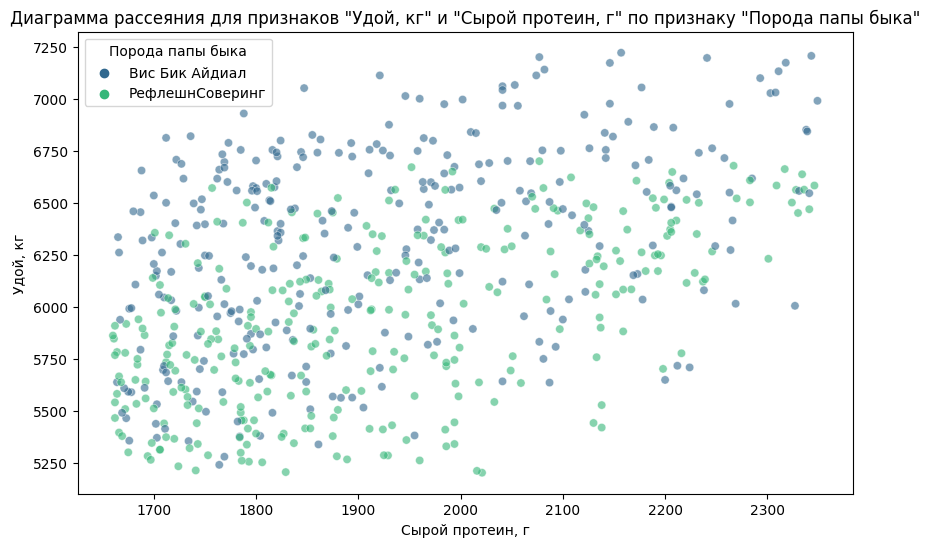

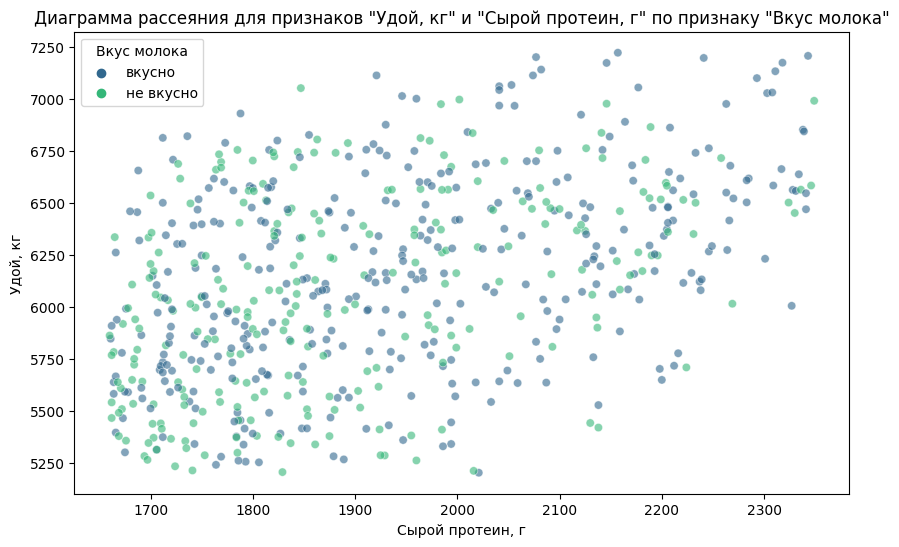

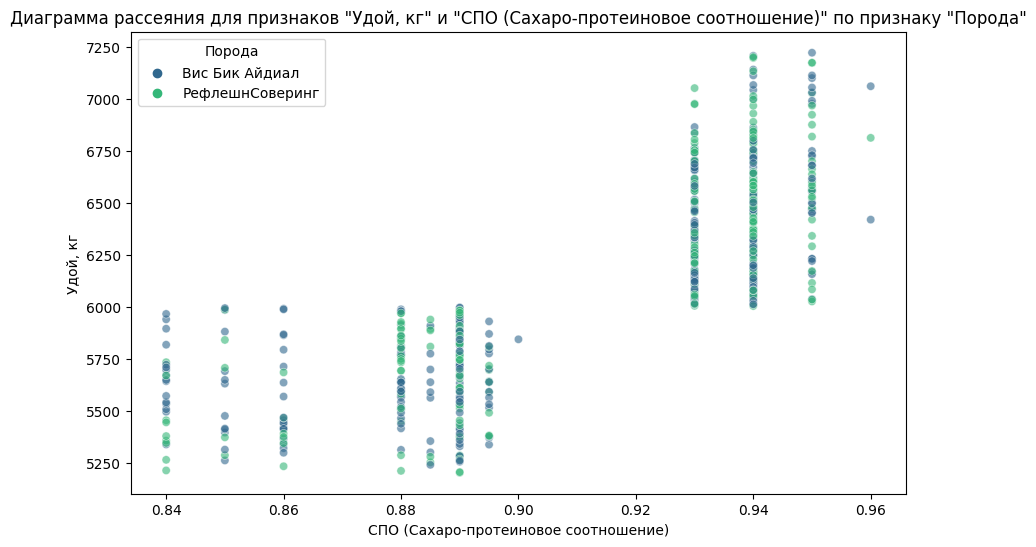

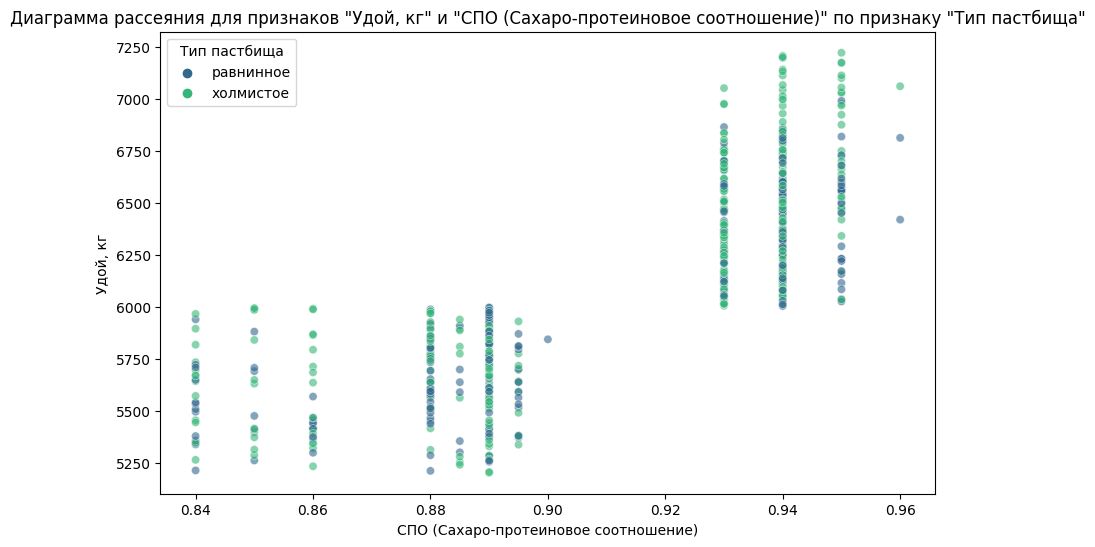

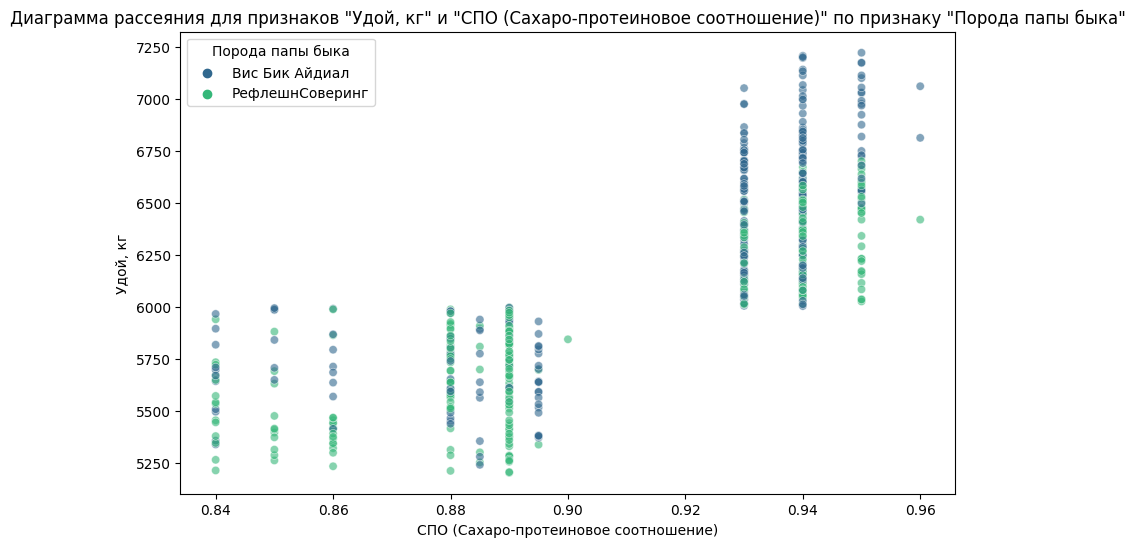

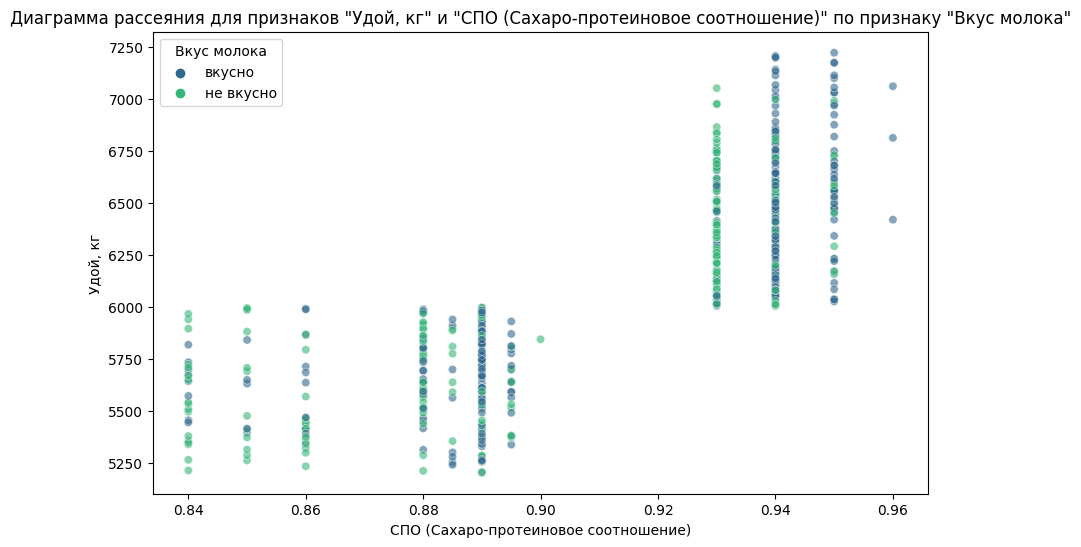

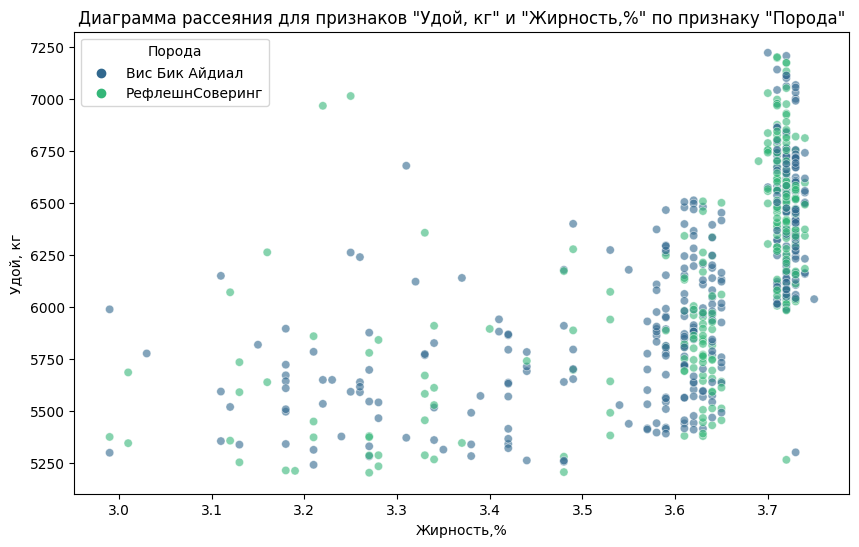

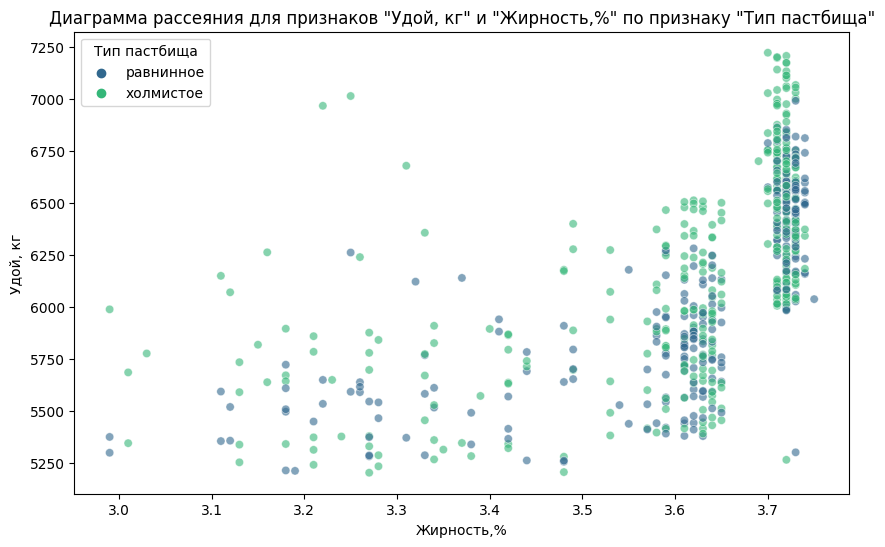

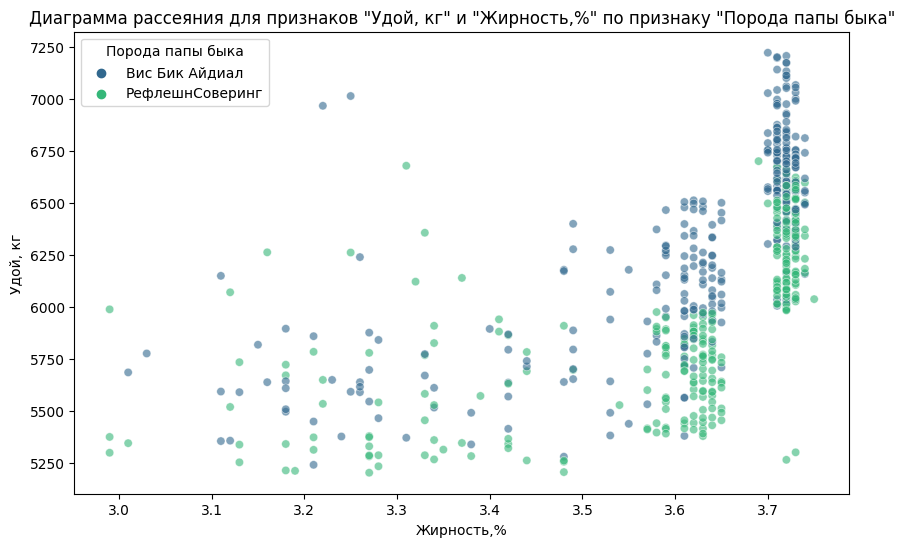

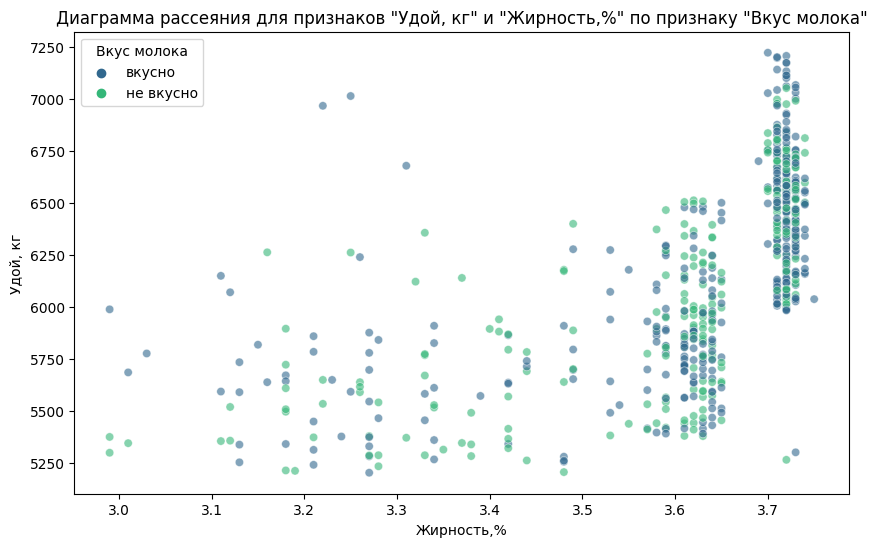

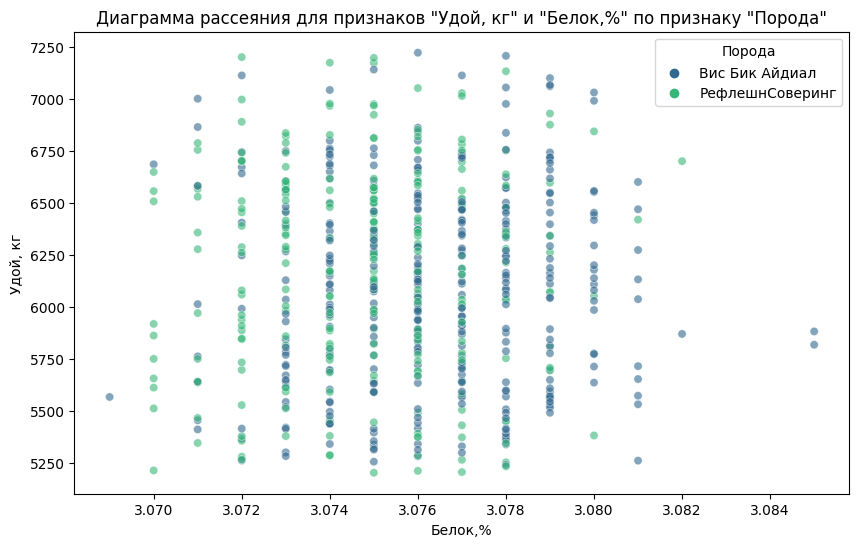

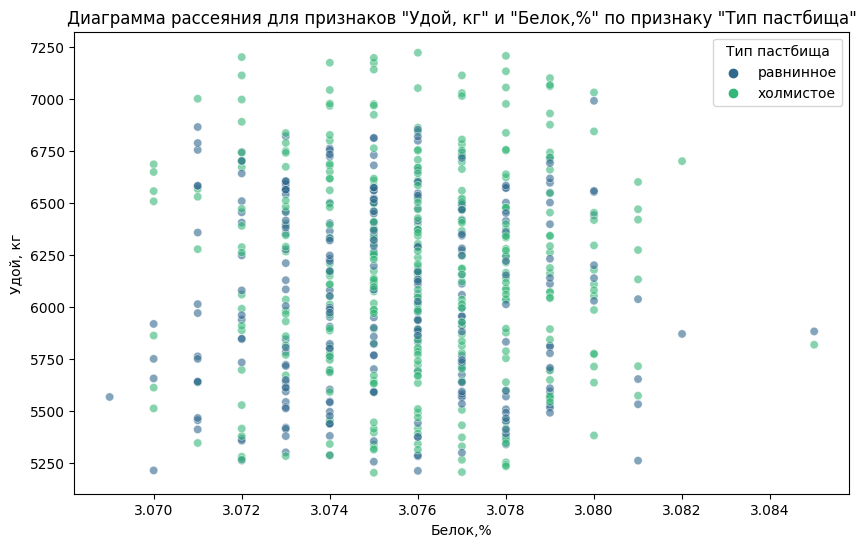

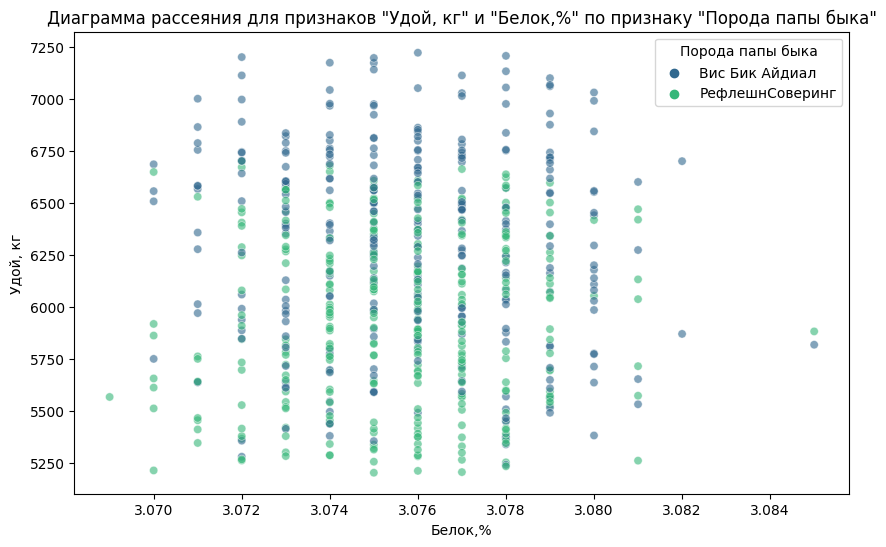

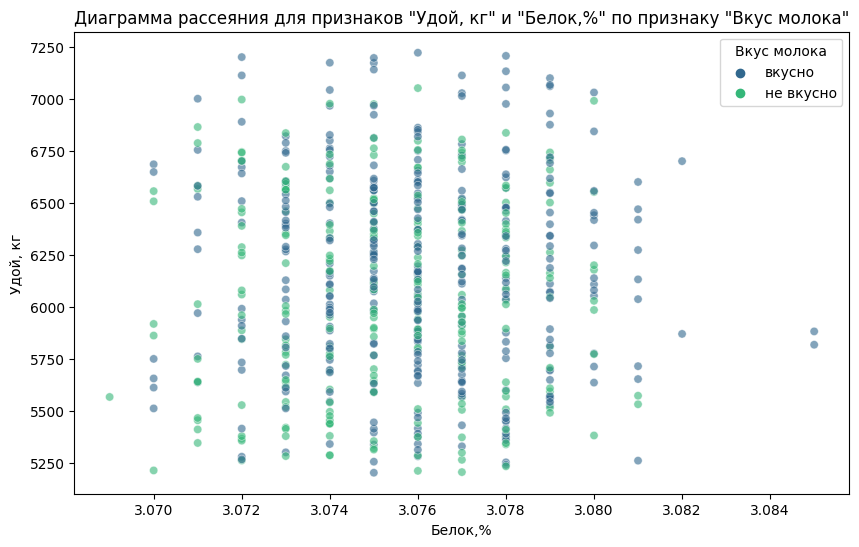

In [351]:
# Списки для интересующих нас количественных и категориальных переменных
numerical_features = {
    'nutritional_energy_unit':'ЭКЕ (Энергетическая кормовая единица)',
    'crude_protein':'Сырой протеин, г',
    'sugar_protein_ratio':'СПО (Сахаро-протеиновое соотношение)',
    'fat_percent':'Жирность,%',
    'protein_percent':'Белок,%'
}


categorical_features = {
    'breed':'Порода',
    'pasture_type':'Тип пастбища',
    'sire_bull_breed':'Порода папы быка',
    'milk_taste':'Вкус молока'
}

# построим графики для всех комбинаций количественных и категориальных признаков
for numerical_feature, numerical_feature_name  in numerical_features.items():
    for categorical_feature, categorical_feature_name  in categorical_features.items():
        plot_scatter(
            data=ferma_main,
            numerical_feature=numerical_feature,
            categorical_feature=categorical_feature,
            x_label=numerical_feature_name,
            categorical_feature_name=categorical_feature_name,
            numerical_feature_name=numerical_feature_name
        )

_Целевые признаки_ - `milk_yield`, `milk_taste`.

_Входные признаки_:
- `nutritional_energy_unit` - ЭКЕ (Энергетическая кормовая единица),
- `crude_protein` - сырой протеин, г,
- `sugar_protein_ratio` - СПО (Сахаро-протеиновое соотношение),
- `fat_percent` - жирность,%,
- `protein_percent` - белок,%
- `breed` - порода,
- `pasture_type` - тип пастбища,
- `age` - возраст коровы,
- `sire_bull_breed` - порода папы быка.

__Типы взаимосвязи между целевыми и входыми признаками__

Взаимосвязь целевого признака `milk_yield` с входными:

- age - очень сильная взаимосвязь;
- nutritional_energy_unit - сильная взаимосвязь, не совсем линейный характер,
- fat_percent - сильная взаимосвязь, диаграмма рассеяния говорит о нелинейном характере связи,
- sugar_protein_ratio - связь средней силы, исходя из диаграмм рассеяния зависимость нелинейная,
- sire_bull_breed - связь средней силы,
- crude_protein - умеренная взаимосвязь,
- breed,  pasture_type - слабая взаимосвязь,
- protein_percent - взаимосвязь не обнаружена.


Взаимосвязь целевого признака `milk_taste` с входными:

- связь средней силы: sugar_protein_ratio,
- слабая взаимосвязь: nutritional_energy_unit, crude_protein, pasture_type, fat_percent, protein_percent, age,
- не выявлена взаимосвязь: breed, sire_bull_breed.

__Промежуточный вывод__:
- рассчитали коэффициенты корреляции между признаками;
- мультиколлинеарности между входными признаками нет;
- выявили очень сильную взаимосвязь целевого признака milk_yield с age, сильную не совсем линейную взаимосвязь с nutritional_energy_unit, fat_percent, нелинейную связь средней силы с sugar_protein_ratio, связь средней силы с sire_bull_breed, умеренную взаимосвязь с crude_protein, слабую взаимосвязь с breed, pasture_type, отсутсвие связи с protein_percent.
- выявили связь средней силы целевого признака milk_taste с sugar_protein_ratio, age, слабую взаимосвязь с nutritional_energy_unit, crude_protein, pasture_type, fat_percent, protein_percent, age, отсутствие взаимосвязи с breed, sire_bull_breed;
- требуется введение новых признаков, чтобы изменить нелинейные взаимосвязи.

## Обучение модели линейной регрессии

In [352]:
class RegressionModel:
    """
    Класс для построения и оценки модели линейной регрессии на основе входных данных.
    """
    
    def __init__(self, dataset, target, cat_col_names, num_col_names, random_state=RANDOM_STATE):
        """
        Инициализация объекта модели с данными и параметрами.
        
        :param dataset: DataFrame с данными
        :param target: Целевой признак
        :param cat_col_names: Список категориальных признаков
        :param num_col_names: Список числовых признаков
        :param random_state: Параметр для воспроизводимости разделения данных
        """
        self._dataset = dataset
        self._target = target
        self._cat_col_names = cat_col_names
        self._num_col_names = num_col_names
        self._random_state = random_state
        self._model = None
        self._metrics = {}
        self._predictions = None
        self._X_train = None
        self._X_test = None
        self._y_train = None
        self._y_test = None
        self._encoder = None
        self._scaler = None

        # Подготовка данных, обучение и предсказание
        self.__prepare_data()
        self.__train_model_and_predict()
        self.__evaluate_model()

    def __prepare_data(self):
        """
        Подготовка данных: кодирование категориальных признаков и масштабирование числовых признаков.
        """
        # Сохраним входные признаки в переменную X и целевой признак в переменную y
        X = self._dataset.drop(self._target, axis=1)
        y = self._dataset[self._target]
        
        # Разделим данные на тренировочную и тестовую выборки
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=self._random_state)
        
        # Инициализируем метод кодирования
        self._encoder = OneHotEncoder(drop='first', sparse=False)
        X_train_ohe = self._encoder.fit_transform(X_train[self._cat_col_names]) 
        X_test_ohe = self._encoder.transform(X_test[self._cat_col_names]) 
        encoder_col_names = self._encoder.get_feature_names_out(self._cat_col_names)
        X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
        X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)
        
        # Инициализируем метод масштабирования
        self._scaler = StandardScaler()
        X_train_scaled = self._scaler.fit_transform(X_train[self._num_col_names])
        X_test_scaled = self._scaler.transform(X_test[self._num_col_names])
        X_train_scaled = pd.DataFrame(X_train_scaled, columns=self._num_col_names)
        X_test_scaled = pd.DataFrame(X_test_scaled, columns=self._num_col_names)
        
        # Объединяем все преобразованные данные в тренировочный и тестовый датафреймы
        self._X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
        self._X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)
        self._y_train = y_train
        self._y_test = y_test

    def __train_model_and_predict(self):
        """
        Обучение модели линейной регрессии и получение предсказаний.
        """
        self._model = LinearRegression()
        self._model.fit(self._X_train, self._y_train)
        self._predictions = self._model.predict(self._X_test)

    def __evaluate_model(self):
        """
        Оценка модели: рассчет метрик R2, MAE, MSE, RMSE.
        """
        r2 = r2_score(self._y_test, self._predictions)
        mae = mean_absolute_error(self._y_test, self._predictions)
        mse = mean_squared_error(self._y_test, self._predictions)
        rmse = mean_squared_error(self._y_test, self._predictions, squared=False)
        
        self._metrics = {
            'R2': r2,
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse
        }

    def get_metrics(self):
        """
        Возвращает метрики модели в виде словаря.
        """
        return self._metrics
    
    def get_predictions(self, X_real):
        """
        Возвращает предсказанные моделью значения для реальных данных X_real.
        """
        # Применяем кодирование категориальных признаков
        X_real_ohe = self._encoder.transform(X_real[self._cat_col_names])
        encoder_col_names = self._encoder.get_feature_names_out(self._cat_col_names)
        X_real_ohe = pd.DataFrame(X_real_ohe, columns=encoder_col_names)
        
        # Применяем масштабирование числовых признаков
        X_real_scaled = self._scaler.transform(X_real[self._num_col_names])
        X_real_scaled = pd.DataFrame(X_real_scaled, columns=self._num_col_names)
        
        # Объединяем преобразованные данные
        X_real_transformed = pd.concat([X_real_ohe, X_real_scaled], axis=1)
        
        # Возвращаем предсказания модели
        return self._model.predict(X_real_transformed)
    
    def get_residuals_diagrams(self):
        """
        Построение графиков распределения остатков и дисперсии.
        """
        # Рассчитываем остатки
        residuals = self._y_test - self._predictions

        # Строим гистограмму частотности и диаграмму рассеяния
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
        axes[0].hist(residuals, bins=30)
        axes[0].set_title('Гистограмма распределения остатков')
        axes[0].set_xlabel('Остатки')
        axes[0].set_ylabel('Частота')

        axes[1].scatter(self._predictions, residuals)
        axes[1].set_xlabel('Предсказания модели')
        axes[1].set_ylabel('Остатки')
        axes[1].set_title('Анализ дисперсии')
        plt.tight_layout()
        plt.show()
        
    def get_prediction_intervals(self):
        """
        Вычисление границ доверительного интервала.
        Устанавливаем двусторонний доверительный интервал, с уровнем доверия 95%.
        """
        # рассчитаем предсказания на тренировочных данных и вычислим ошибки модели
        train_predictions = self._model.predict(self._X_train)
        errors = self._y_train - train_predictions
        
        # рассчитаем квантили ошибок
        lower_quantile = np.quantile(errors, 0.025)
        upper_quantile = np.quantile(errors, 0.975)
        
        return lower_quantile, upper_quantile

### Обучение первой модели линейной регрессии

Целевой признак - milk_yield. 

Из входных признаков отбросим следующие признаки, т.к. они не оказывают никакого влияния на целевой: `id`, `milk_taste`. Также не будем учитывать процентное содержание жира и белка в молоке. Показатель `protein_percent` не имеет взаимосвязи с целевым признаком. Признаки `sugar_protein_ratio`,  `fat_percent` отбросим из-за нелинейной связи.

До обучения модели закодируем категориальные данные и выполним масштабирование численных признаков. Обучим модель линейной регрессии на подготовленных данных. Получим предсказания на тестовых данных и оценим качество модели используя коэффициент детерминации и проанализировав остатки.

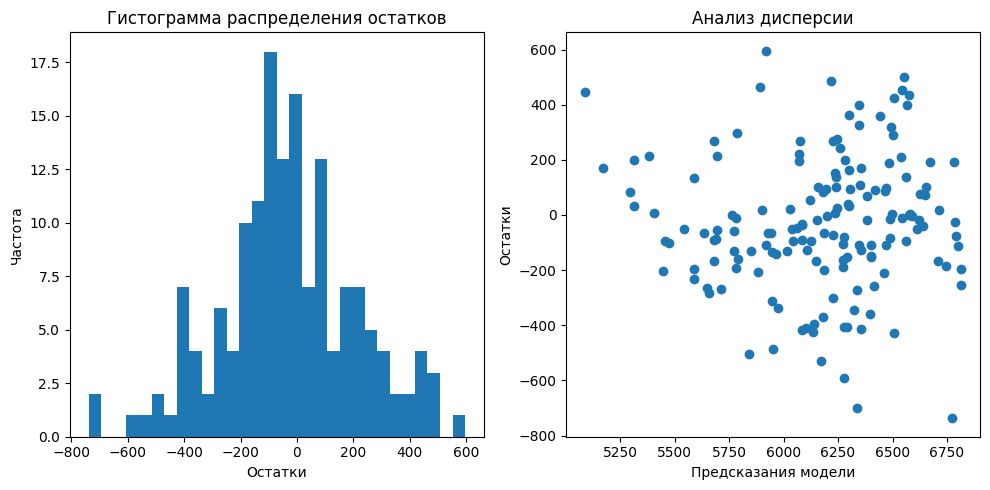

R2 = 0.7055645780421288


In [353]:
model_1 = RegressionModel(
    ferma_main.drop(['id', 'milk_taste', 'protein_percent', 'fat_percent', 'sugar_protein_ratio'], axis = 1),
    target='milk_yield',
    cat_col_names=['breed','pasture_type', 'sire_bull_breed', 'age'],
    num_col_names=['nutritional_energy_unit', 'crude_protein'])
model_1.get_residuals_diagrams()
print(f'R2 = {model_1.get_metrics()["R2"]}')

__Выводы__:
Для нашей первой обученной модели R2=0.706. Модель полезна, но не идеальна и требует улучшения. Изучим графики остатков. Распределение остатков нессиметричное мультимодальное (несколько пиков). Есть выбросы. Модель дает как завышенные, так и заниженные предсказания. Модель может работать неустойчиво, поскольку разброс остатков непостоянен. Такую модель использовать в работе нельзя.

_Модель нельзя использовать_. Нужны дополнительные исследования: дополнительные признаки, трансформация данных.

### Обучение второй модели

Перед обучением второй модели, еще немного подготовим наши данные. Избавимся от нелинейной связи вхходных признаков с целевым, чтобы эти признаки были информативны для линейной регрессии. 

1. `milk_yield` и `sugar_protein_ratio` связаны нелинейно. На диаграмме рассеяния наблюдения сгруппированы в два кластера, больше и меньше 0.92. Для устранения нелинейности, преобразуем СПО в категориальный бинарный признак.

2. `milk_yield` и `nutritional_energy_unit` - на диаграмме заметен не совсем линейный характер связи. Введем новый признак ЭКЕ в квадрате.

In [354]:
# пороговое значение
threshold = 0.92

ferma_main['sugar_protein_ratio_cat'] = ferma_main['sugar_protein_ratio'].apply(lambda x: 1 if x >= 0.92 else 0)
ferma_main['nutritional_energy_unit_squared'] = ferma_main['nutritional_energy_unit'].apply(lambda x: x**2)

ferma_main

id  milk_yield  nutritional_energy_unit  crude_protein  \
0      1        5863                    14.20           1743   
1      2        5529                    12.80           2138   
2      3        5810                    14.00           1854   
3      4        5895                    12.40           2012   
4      5        5302                    12.80           1675   
..   ...         ...                      ...            ...   
624  625        6812                    15.40           1964   
625  626        5513                    12.90           1700   
626  627        5970                    14.40           1837   
627  628        5746                    13.80           1994   
628  629        6503                    16.20           2283   

     sugar_protein_ratio            breed pasture_type  sire_bull_breed  \
0                   0.89   Вис Бик Айдиал    равнинное   Вис Бик Айдиал   
1                   0.89   Вис Бик Айдиал    равнинное  РефлешнСоверинг   
2                   0.89  РефлешнСоверинг    холмистое  РефлешнСоверинг   
3                   0.89  РефлешнСоверинг    холмистое   Вис Бик Айдиал   
4                   0.89   Вис Бик Айдиал    равнинное  РефлешнСоверинг   
..                   ...              ...          ...              ...   
624                 0.94  РефлешнСоверинг    равнинное   Вис Бик Айдиал   
625                 0.88  РефлешнСоверинг    равнинное  РефлешнСоверинг   
626                 0.88  РефлешнСоверинг    холмистое  РефлешнСоверинг   
627                 0.89  РефлешнСоверинг    равнинное  РефлешнСоверинг   
628                 0.94   Вис Бик Айдиал    холмистое  РефлешнСоверинг   

     fat_percent  protein_percent milk_taste          age  \
0           3.58             3.08     вкусно  более_2_лет   
1           3.54             3.08     вкусно  менее_2_лет   
2           3.59             3.07  не вкусно  более_2_лет   
3           3.40             3.08  не вкусно  более_2_лет   
4           3.73             3.07     вкусно  менее_2_лет   
..           ...              ...        ...          ...   
624         3.74             3.08  не вкусно  более_2_лет   
625         3.64             3.07     вкусно  менее_2_лет   
626         3.64             3.08  не вкусно  более_2_лет   
627         3.64             3.08     вкусно  более_2_лет   
628         3.71             3.08     вкусно  более_2_лет   

     sugar_protein_ratio_cat  nutritional_energy_unit_squared  
0                          0                           201.64  
1                          0                           163.84  
2                          0                           196.00  
3                          0                           153.76  
4                          0                           163.84  
..                       ...                              ...  
624                        1                           237.16  
625                        0                           166.41  
626                        0                           207.36  
627                        0                           190.44  
628                        1                           262.44  

[628 rows x 14 columns]

Обучим новую модель, добавив к входным признакам `sugar_protein_ratio_cat` и в этот раз используя `nutritional_energy_unit_squared`.

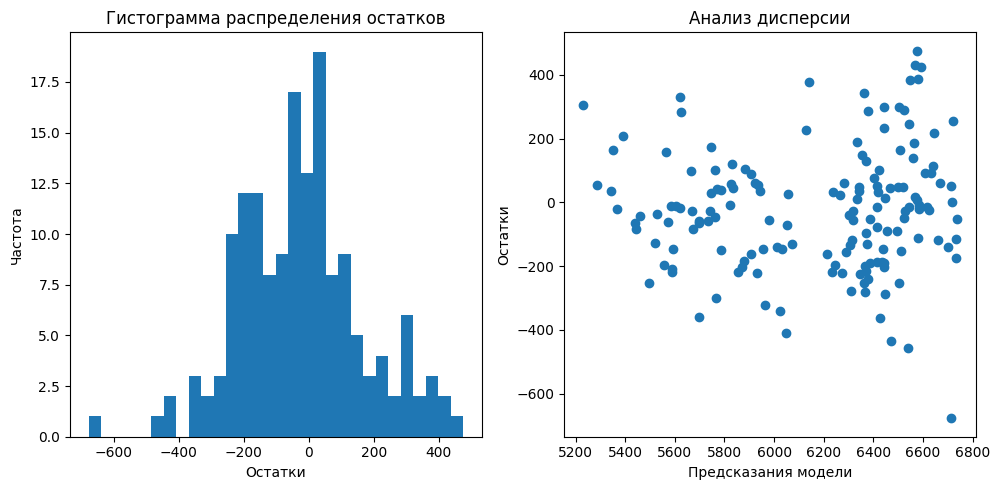

R2 = 0.8180879926867501


In [355]:
model_2 = RegressionModel(
    ferma_main.drop(['id', 'milk_taste', 'protein_percent', 'fat_percent', 'nutritional_energy_unit', 'sugar_protein_ratio'], axis = 1),
    target='milk_yield',
    cat_col_names=['breed','pasture_type', 'sire_bull_breed', 'sugar_protein_ratio_cat','age'],
    num_col_names=['nutritional_energy_unit_squared', 'crude_protein'])
model_2.get_residuals_diagrams()
print(f'R2 = {model_2.get_metrics()["R2"]}')

__Выводы__:
Для второй обученной модели R2=0.818. Показатель улучшился. Распределение остатков все ёще содержит выбросы, а также не имеет одного четкого пика. Модель дает и завышенные, и заниженные предсказания. Разброс остатков модели снова непостоянен, однако выглядит лучше предыдущего.

_Модель требует доработки_. Нужны дополнительные исследования: дополнительные признаки, трансформация данных.

### Обучение третьей модели

Перед обучением новой модели, добавим к данным новый признак - имя папы из файла ferma_dad.csv. 

In [356]:
ferma_main = ferma_main.merge(ferma_dad, on='id', how='left')

In [357]:
ferma_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 628 entries, 0 to 627
Data columns (total 15 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               628 non-null    int64  
 1   milk_yield                       628 non-null    int64  
 2   nutritional_energy_unit          628 non-null    float64
 3   crude_protein                    628 non-null    int64  
 4   sugar_protein_ratio              628 non-null    float64
 5   breed                            628 non-null    object 
 6   pasture_type                     628 non-null    object 
 7   sire_bull_breed                  628 non-null    object 
 8   fat_percent                      628 non-null    float64
 9   protein_percent                  628 non-null    float64
 10  milk_taste                       628 non-null    object 
 11  age                              628 non-null    object 
 12  sugar_protein_ratio_ca

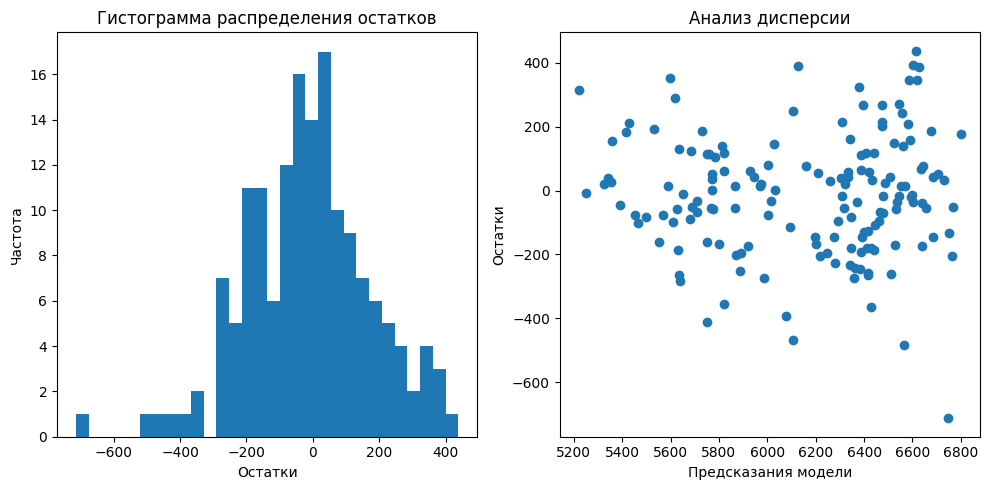

R2 = 0.8247542745210408


In [358]:
model_3 = RegressionModel(
    ferma_main.drop(
        ['id', 'milk_taste', 'protein_percent', 'fat_percent', 'nutritional_energy_unit', 'sugar_protein_ratio'], axis = 1),
    target='milk_yield',
    cat_col_names=['breed','pasture_type', 'sire_bull_breed', 'sugar_protein_ratio_cat','age', 'sire_name'],
    num_col_names=['nutritional_energy_unit_squared', 'crude_protein'])
model_3.get_residuals_diagrams()
print(f'R2 = {model_3.get_metrics()["R2"]}')

__Выводы__:
Для третьей обученной модели R2=0.825. Показатель немного улучшился. Распределение остатков выглядит лучше, но все еще не является нормальным. Присутствует небольшое количество выбросов. Модель дает и завышенные, и заниженные предсказания. Если не учитывать один выброс, то разброс остатков модели постоянный.

_Модель все еще не идеальна и может быть улучшена_.

### Сравнение трех моделей

Сравнивая модели по R2 и остаткам, приходим к выводу, что третья модель - лучшая, несмотря на то, что графики остатков не идеальны, для нее распределение остатков ближе всего к нормальному по форме, а также постоянное распределение остатков (если не учитывать небольшое количество выбросов).

In [359]:
metrics = pd.DataFrame({
    'model_1': model_1.get_metrics(),
    'model_2': model_2.get_metrics(),
    'model_3': model_3.get_metrics()
})
metrics

model_1   model_2   model_3
R2        0.71      0.82      0.82
MAE     189.22    149.04    146.16
MSE  59,936.74 37,030.91 35,673.89
RMSE    244.82    192.43    188.88

Метрики также говорят нам о том, что третья моделья - самая удачная: среднеквадратичная ошибка, а соответственно и корень среднеквадратичной ошибки, наименьший среди трех моделей. Коэффициент детерминации R2 также для нее ближе всего к 1 (если смотреть на неокругленное значение), а средняя абсолютная ошибка ближе всего к нулю.

In [360]:
# определим доверительный интервал прогноза лучшей модели
model_3.get_prediction_intervals()

(-355.98806203826985, 363.2434912844644)

Спрогнозируем удой коров "ЭкоФермы". 

Добавим недостающие признаки недостающие признаки в датасет. Известно, что планируется увеличение значений параметров корма на 5%. Заполним значения ЭКЕ, сырого протеина и СПО средними значениями из датасета ferma_main.csv, увеличенными на 5%.

In [361]:
cow_buy['nutritional_energy_unit'] = ferma_main['nutritional_energy_unit'].mean()*1.05
cow_buy['crude_protein'] = ferma_main['crude_protein'].mean()*1.05
cow_buy['sugar_protein_ratio'] = ferma_main['sugar_protein_ratio'].mean()*1.05

cow_buy['nutritional_energy_unit_squared'] = cow_buy['nutritional_energy_unit'].apply(lambda x: x**2)
cow_buy['sugar_protein_ratio_cat'] = cow_buy['sugar_protein_ratio'].apply(lambda x: 1 if x >= 0.92 else 0)

cow_buy

breed pasture_type  sire_bull_breed sire_name  fat_percent  \
0    Вис Бик Айдиал    холмистое   Вис Бик Айдиал  Геркулес         3.58   
1    Вис Бик Айдиал    равнинное  РефлешнСоверинг    Буйный         3.54   
2   РефлешнСоверинг    равнинное  РефлешнСоверинг     Барин         3.59   
3   РефлешнСоверинг    холмистое   Вис Бик Айдиал    Буйный         3.40   
4   РефлешнСоверинг    равнинное   Вис Бик Айдиал    Буйный         3.64   
5   РефлешнСоверинг    равнинное  РефлешнСоверинг  Геркулес         3.63   
6    Вис Бик Айдиал    холмистое   Вис Бик Айдиал  Геркулес         3.58   
7    Вис Бик Айдиал    равнинное  РефлешнСоверинг    Буйный         3.57   
8   РефлешнСоверинг    равнинное  РефлешнСоверинг     Барин         3.59   
9   РефлешнСоверинг    холмистое   Вис Бик Айдиал    Буйный         3.40   
10   Вис Бик Айдиал    холмистое  РефлешнСоверинг  Соловчик         3.73   
11  РефлешнСоверинг    равнинное  РефлешнСоверинг  Геркулес         3.73   
12   Вис Бик Айдиал    холмистое   Вис Бик Айдиал  Геркулес         3.68   
13   Вис Бик Айдиал    холмистое  РефлешнСоверинг     Барин         3.42   
14  РефлешнСоверинг    равнинное  РефлешнСоверинг     Барин         3.59   
15  РефлешнСоверинг    холмистое   Вис Бик Айдиал    Буйный         3.40   
16   Вис Бик Айдиал    холмистое  РефлешнСоверинг  Соловчик         3.73   
17  РефлешнСоверинг    равнинное  РефлешнСоверинг  Геркулес         3.77   
18   Вис Бик Айдиал    равнинное  РефлешнСоверинг    Буйный         3.34   
19  РефлешнСоверинг    равнинное   Вис Бик Айдиал    Буйный         3.64   

    protein_percent          age  nutritional_energy_unit  crude_protein  \
0              3.08  более_2_лет                    15.28       2,019.95   
1              3.08  менее_2_лет                    15.28       2,019.95   
2              3.07  более_2_лет                    15.28       2,019.95   
3              3.06  более_2_лет                    15.28       2,019.95   
4              3.07  более_2_лет                    15.28       2,019.95   
5              3.05  менее_2_лет                    15.28       2,019.95   
6              3.08  более_2_лет                    15.28       2,019.95   
7              3.08  более_2_лет                    15.28       2,019.95   
8              3.07  более_2_лет                    15.28       2,019.95   
9              3.08  менее_2_лет                    15.28       2,019.95   
10             3.06  более_2_лет                    15.28       2,019.95   
11             3.07  более_2_лет                    15.28       2,019.95   
12             3.05  более_2_лет                    15.28       2,019.95   
13             3.08  менее_2_лет                    15.28       2,019.95   
14             3.07  более_2_лет                    15.28       2,019.95   
15             3.06  более_2_лет                    15.28       2,019.95   
16             3.08  более_2_лет                    15.28       2,019.95   
17             3.05  менее_2_лет                    15.28       2,019.95   
18             3.07  более_2_лет                    15.28       2,019.95   
19             3.07  более_2_лет                    15.28       2,019.95   

    sugar_protein_ratio  nutritional_energy_unit_squared  \
0                  0.96                           233.36   
1                  0.96                           233.36   
2                  0.96                           233.36   
3                  0.96                           233.36   
4                  0.96                           233.36   
5                  0.96                           233.36   
6                  0.96                           233.36   
7                  0.96                           233.36   
8                  0.96                           233.36   
9                  0.96                           233.36   
10                 0.96                           233.36   
11                 0.96                           233.36   
12                 0.96                 

In [362]:
cow_buy['milk_yield'] = model_3.get_predictions(
    cow_buy.drop(
        ['protein_percent', 'fat_percent', 'nutritional_energy_unit', 'sugar_protein_ratio'],
        axis = 1)
)
cow_buy

breed pasture_type  sire_bull_breed sire_name  fat_percent  \
0    Вис Бик Айдиал    холмистое   Вис Бик Айдиал  Геркулес         3.58   
1    Вис Бик Айдиал    равнинное  РефлешнСоверинг    Буйный         3.54   
2   РефлешнСоверинг    равнинное  РефлешнСоверинг     Барин         3.59   
3   РефлешнСоверинг    холмистое   Вис Бик Айдиал    Буйный         3.40   
4   РефлешнСоверинг    равнинное   Вис Бик Айдиал    Буйный         3.64   
5   РефлешнСоверинг    равнинное  РефлешнСоверинг  Геркулес         3.63   
6    Вис Бик Айдиал    холмистое   Вис Бик Айдиал  Геркулес         3.58   
7    Вис Бик Айдиал    равнинное  РефлешнСоверинг    Буйный         3.57   
8   РефлешнСоверинг    равнинное  РефлешнСоверинг     Барин         3.59   
9   РефлешнСоверинг    холмистое   Вис Бик Айдиал    Буйный         3.40   
10   Вис Бик Айдиал    холмистое  РефлешнСоверинг  Соловчик         3.73   
11  РефлешнСоверинг    равнинное  РефлешнСоверинг  Геркулес         3.73   
12   Вис Бик Айдиал    холмистое   Вис Бик Айдиал  Геркулес         3.68   
13   Вис Бик Айдиал    холмистое  РефлешнСоверинг     Барин         3.42   
14  РефлешнСоверинг    равнинное  РефлешнСоверинг     Барин         3.59   
15  РефлешнСоверинг    холмистое   Вис Бик Айдиал    Буйный         3.40   
16   Вис Бик Айдиал    холмистое  РефлешнСоверинг  Соловчик         3.73   
17  РефлешнСоверинг    равнинное  РефлешнСоверинг  Геркулес         3.77   
18   Вис Бик Айдиал    равнинное  РефлешнСоверинг    Буйный         3.34   
19  РефлешнСоверинг    равнинное   Вис Бик Айдиал    Буйный         3.64   

    protein_percent          age  nutritional_energy_unit  crude_protein  \
0              3.08  более_2_лет                    15.28       2,019.95   
1              3.08  менее_2_лет                    15.28       2,019.95   
2              3.07  более_2_лет                    15.28       2,019.95   
3              3.06  более_2_лет                    15.28       2,019.95   
4              3.07  более_2_лет                    15.28       2,019.95   
5              3.05  менее_2_лет                    15.28       2,019.95   
6              3.08  более_2_лет                    15.28       2,019.95   
7              3.08  более_2_лет                    15.28       2,019.95   
8              3.07  более_2_лет                    15.28       2,019.95   
9              3.08  менее_2_лет                    15.28       2,019.95   
10             3.06  более_2_лет                    15.28       2,019.95   
11             3.07  более_2_лет                    15.28       2,019.95   
12             3.05  более_2_лет                    15.28       2,019.95   
13             3.08  менее_2_лет                    15.28       2,019.95   
14             3.07  более_2_лет                    15.28       2,019.95   
15             3.06  более_2_лет                    15.28       2,019.95   
16             3.08  более_2_лет                    15.28       2,019.95   
17             3.05  менее_2_лет                    15.28       2,019.95   
18             3.07  более_2_лет                    15.28       2,019.95   
19             3.07  более_2_лет                    15.28       2,019.95   

    sugar_protein_ratio  nutritional_energy_unit_squared  \
0                  0.96                           233.36   
1                  0.96                           233.36   
2                  0.96                           233.36   
3                  0.96                           233.36   
4                  0.96                           233.36   
5                  0.96                           233.36   
6                  0.96                           233.36   
7                  0.96                           233.36   
8                  0.96                           233.36   
9                  0.96                           233.36   
10                 0.96                           233.36   
11                 0.96                           233.36   
12                 0.96                 

__Промежуточный вывод__:
- обучили три модели линейной регрессии, обученных на разных входных признаках;
- вычислили для них метрики, провели анализ остатков;
- выбрали лучшую модель;
- определили доверительный интервал прогноза лучшей модели;
- спрогнозировали удой коров "ЭкоФермы".

## Обучение модели логистической регрессии

In [ ]:
class LogisticRegressionModel:
    """
    Класс для построения и оценки модели логистической регрессии на основе входных данных.
    """
    
    def __init__(self, dataset, target, cat_col_names, num_col_names, threshold=0.5, random_state=RANDOM_STATE):
        """
        Инициализация объекта модели с данными и параметрами.
        
        :param dataset: DataFrame с данными
        :param target: Целевой признак
        :param cat_col_names: Список категориальных признаков
        :param num_col_names: Список числовых признаков
        :param threshold: Пороговое значение для классификации
        :param random_state: Параметр для воспроизводимости разделения данных
        """
        self._dataset = dataset
        self._target = target
        self._cat_col_names = cat_col_names
        self._num_col_names = num_col_names
        self._random_state = random_state
        self._model = None
        self._metrics = {}
        self._predictions = None
        self._X_train = None
        self._X_test = None
        self._y_train = None
        self._y_test = None
        self._encoder = None
        self._scaler = None
        self._threshold = threshold

        # Подготовка данных, обучение и предсказание
        self.__prepare_data()
        self.__train_model()
        self.__predict()
        self.__evaluate_model()

    def __prepare_data(self):
        """
        Подготовка данных: кодирование категориальных признаков и масштабирование числовых признаков.
        """
        # Сохраним входные признаки в переменную X и целевой признак в переменную y
        X = self._dataset.drop(self._target, axis=1)
        y = self._dataset[self._target]
        
        # Разделим данные на тренировочную и тестовую выборки
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=self._random_state)
        
        # Инициализируем метод кодирования
        self._encoder = OneHotEncoder(drop='first', sparse=False)
        X_train_ohe = self._encoder.fit_transform(X_train[self._cat_col_names]) 
        X_test_ohe = self._encoder.transform(X_test[self._cat_col_names]) 
        encoder_col_names = self._encoder.get_feature_names_out(self._cat_col_names)
        X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
        X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)
        
        # Инициализируем метод масштабирования
        self._scaler = StandardScaler()
        X_train_scaled = self._scaler.fit_transform(X_train[self._num_col_names])
        X_test_scaled = self._scaler.transform(X_test[self._num_col_names])
        X_train_scaled = pd.DataFrame(X_train_scaled, columns=self._num_col_names)
        X_test_scaled = pd.DataFrame(X_test_scaled, columns=self._num_col_names)
        
        # Объединяем все преобразованные данные в тренировочный и тестовый датафреймы
        self._X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
        self._X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)
        self._y_train = y_train
        self._y_test = y_test

    def __train_model(self):
        """
        Обучение модели логистической регрессии.
        """
        self._model = LogisticRegression()
        self._model.fit(self._X_train, self._y_train)
        
    def __predict(self):
        """
        Получение предсказаний модели логистической регрессии.
        """
        y_pred_proba = self._model.predict_proba(self._X_test)[:, 1]
        self._predictions = (y_pred_proba >= self._threshold).astype(int)

    def __evaluate_model(self):
        """
        Рассчитывает метрики для логистической модели на основе тестовых и предсказанных значений.
        """
        recall = recall_score(self._y_test, self._predictions)
        precision = precision_score(self._y_test, self._predictions)
        accuracy = accuracy_score(self._y_test, self._predictions)
    
        self._metrics = {
            'recall': recall,
            'precision': precision,
            'accuracy': accuracy
        }
        
    def show_metrics(self):
        """
        Выводит значения метрик.
        """
        print('accuracy: ', round(self._metrics['accuracy'], 3))
        print('recall: ', round(self._metrics['recall'], 3))
        print('precision: ', round(self._metrics['precision'], 3))
        
    def get_metrics(self):
        """
        Возвращает значения метрик.
        """
        return self._metrics
    
    def get_predictions(self, X_real):
        """
        Возвращает предсказанные моделью значения для реальных данных X_real.
        """
        # Применяем кодирование категориальных признаков
        X_real_ohe = self._encoder.transform(X_real[self._cat_col_names])
        encoder_col_names = self._encoder.get_feature_names_out(self._cat_col_names)
        X_real_ohe = pd.DataFrame(X_real_ohe, columns=encoder_col_names)
        
        # Применяем масштабирование числовых признаков
        X_real_scaled = self._scaler.transform(X_real[self._num_col_names])
        X_real_scaled = pd.DataFrame(X_real_scaled, columns=self._num_col_names)
        
        # Объединяем преобразованные данные
        X_real_transformed = pd.concat([X_real_ohe, X_real_scaled], axis=1)
        
        # Возвращаем предсказания модели
        y_pred_proba = self._model.predict_proba(X_real_transformed)[:, 1]
        return (y_pred_proba >= self._threshold).astype(int)
    
    def plot_confusion_matrix(self):
        """
        Строит матрицу ошибок для заданных тестовых и предсказанных значений.
        """
        cm = confusion_matrix(self._y_test, self._predictions)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
        plt.xlabel('Предсказанные значения')
        plt.ylabel('Фактические значения')
        plt.title("Confusion Matrix")
        plt.show()
        
    def set_threshold(self, threshold):
        """
        Устанавливает новое пороговое значение и пересчитывает предсказания, матрицу ошибок и метрики.

        :param threshold: Новое пороговое значение для классификации
        """
        self._threshold = threshold
        self.__predict()
        self.__evaluate_model()

Нам нужно решить задачу бинарной классификации. Целевой признак - вкус молока (вкусно, не вкусно). Для бинарной классификации подходит логистическая регрессия. Идентификатор не несет смысловой нагрузки, также удалим созданные для модели линейной регрессии признаки и показатель удоя.

In [364]:
# кодируем классы целевого признака как 1 - вкусно, 0 - не вкусно
ferma_main['milk_taste'] = ferma_main['milk_taste'].apply(lambda x: 1 if x == 'вкусно' else 0)

accuracy:  0.611
recall:  0.852
precision:  0.61


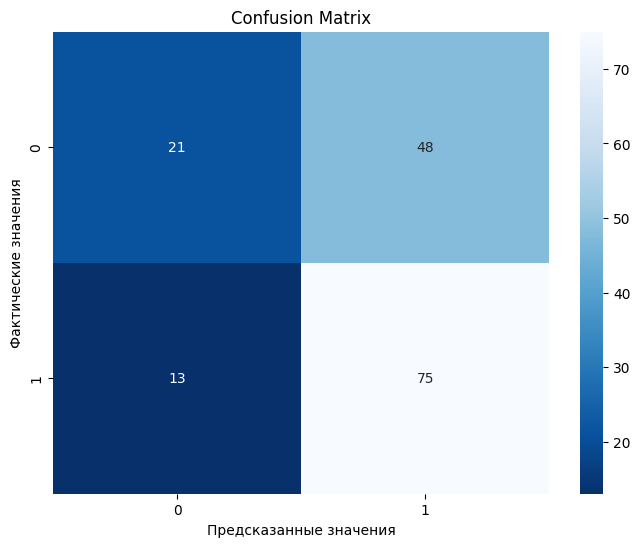

In [365]:
logistic_model = LogisticRegressionModel(
    ferma_main.drop(columns=['id', 'sugar_protein_ratio_cat', 'nutritional_energy_unit_squared', 'milk_yield']),
    target='milk_taste',
    cat_col_names=['breed','pasture_type', 'sire_bull_breed', 'age', 'sire_name'],
    num_col_names=['nutritional_energy_unit', 'crude_protein', 'sugar_protein_ratio', 'fat_percent', 'protein_percent'])

logistic_model.show_metrics()
logistic_model.plot_confusion_matrix()

Доля верных ответов модели составляет 61.1%. Точность, с которой модель присваивает объектам класс 1, составляет 61%. Чем выше precision, тем меньше случаев присвоения класса 1 объектам класса 0. В нашем случае показатель низкий. Чем выше recall, тем больше прогнозов Positive модель смогла дать верно. В нашем случае полнота составляет 85.2%. Довольно хороший показатель.

Т.к. для заказчика приоритетным является получение вкусного молока, то для нас важно свести к минимуму число FalsePositive - ошибок первого рода, которые могут привести к покупке коров, дающих невкусное молоко. Нам нужно добиться показателя precision, равного 1. Для этого подберем подходящий порог принадлежности к классам. Сейчас мы проводили рассчеты со стандартным значением 0.5.

Пороговое значение: 0.8100000000000003
accuracy:  0.465
recall:  0.045
precision:  1.0


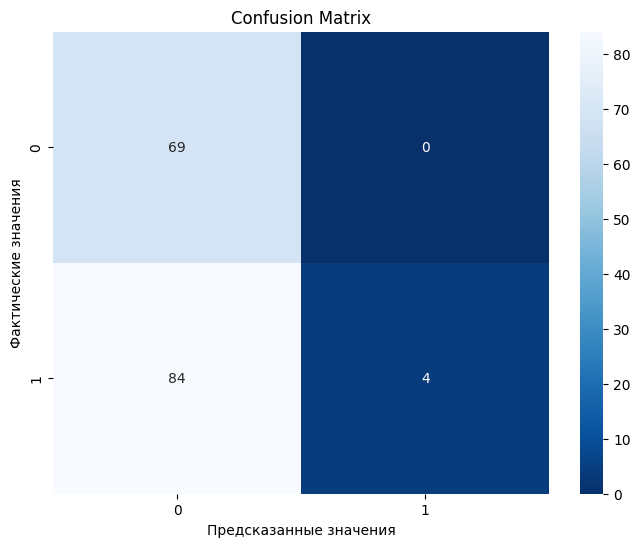

In [366]:
threshold = 0.5

while True:
    threshold += 0.01
    # получаем оценки вероятностей для класса 1
    logistic_model.set_threshold(threshold)
    if (logistic_model.get_metrics()['precision'] == 1):
        break
        
print(f'Пороговое значение: {threshold}') 
logistic_model.show_metrics()
logistic_model.plot_confusion_matrix()

Получили пороговое значение 0.81. Мы свели к нулю ошибки, когда невкусное молоко ошибочно признается вкусным. Однако при этом показатель accuracy снизился до 46.5%, а recall до 4.5%. Количество ошибок второго рода значительно увеличилось.

Получим предсказания модели о вкусе молока и добавим их в датасет с информацией о коровах "ЭкоФермы".

In [367]:
cow_buy['milk_taste'] = logistic_model.get_predictions(
    cow_buy.drop(columns=['sugar_protein_ratio_cat', 'nutritional_energy_unit_squared', 'milk_yield'], axis = 1))
cow_buy

breed pasture_type  sire_bull_breed sire_name  fat_percent  \
0    Вис Бик Айдиал    холмистое   Вис Бик Айдиал  Геркулес         3.58   
1    Вис Бик Айдиал    равнинное  РефлешнСоверинг    Буйный         3.54   
2   РефлешнСоверинг    равнинное  РефлешнСоверинг     Барин         3.59   
3   РефлешнСоверинг    холмистое   Вис Бик Айдиал    Буйный         3.40   
4   РефлешнСоверинг    равнинное   Вис Бик Айдиал    Буйный         3.64   
5   РефлешнСоверинг    равнинное  РефлешнСоверинг  Геркулес         3.63   
6    Вис Бик Айдиал    холмистое   Вис Бик Айдиал  Геркулес         3.58   
7    Вис Бик Айдиал    равнинное  РефлешнСоверинг    Буйный         3.57   
8   РефлешнСоверинг    равнинное  РефлешнСоверинг     Барин         3.59   
9   РефлешнСоверинг    холмистое   Вис Бик Айдиал    Буйный         3.40   
10   Вис Бик Айдиал    холмистое  РефлешнСоверинг  Соловчик         3.73   
11  РефлешнСоверинг    равнинное  РефлешнСоверинг  Геркулес         3.73   
12   Вис Бик Айдиал    холмистое   Вис Бик Айдиал  Геркулес         3.68   
13   Вис Бик Айдиал    холмистое  РефлешнСоверинг     Барин         3.42   
14  РефлешнСоверинг    равнинное  РефлешнСоверинг     Барин         3.59   
15  РефлешнСоверинг    холмистое   Вис Бик Айдиал    Буйный         3.40   
16   Вис Бик Айдиал    холмистое  РефлешнСоверинг  Соловчик         3.73   
17  РефлешнСоверинг    равнинное  РефлешнСоверинг  Геркулес         3.77   
18   Вис Бик Айдиал    равнинное  РефлешнСоверинг    Буйный         3.34   
19  РефлешнСоверинг    равнинное   Вис Бик Айдиал    Буйный         3.64   

    protein_percent          age  nutritional_energy_unit  crude_protein  \
0              3.08  более_2_лет                    15.28       2,019.95   
1              3.08  менее_2_лет                    15.28       2,019.95   
2              3.07  более_2_лет                    15.28       2,019.95   
3              3.06  более_2_лет                    15.28       2,019.95   
4              3.07  более_2_лет                    15.28       2,019.95   
5              3.05  менее_2_лет                    15.28       2,019.95   
6              3.08  более_2_лет                    15.28       2,019.95   
7              3.08  более_2_лет                    15.28       2,019.95   
8              3.07  более_2_лет                    15.28       2,019.95   
9              3.08  менее_2_лет                    15.28       2,019.95   
10             3.06  более_2_лет                    15.28       2,019.95   
11             3.07  более_2_лет                    15.28       2,019.95   
12             3.05  более_2_лет                    15.28       2,019.95   
13             3.08  менее_2_лет                    15.28       2,019.95   
14             3.07  более_2_лет                    15.28       2,019.95   
15             3.06  более_2_лет                    15.28       2,019.95   
16             3.08  более_2_лет                    15.28       2,019.95   
17             3.05  менее_2_лет                    15.28       2,019.95   
18             3.07  более_2_лет                    15.28       2,019.95   
19             3.07  более_2_лет                    15.28       2,019.95   

    sugar_protein_ratio  nutritional_energy_unit_squared  \
0                  0.96                           233.36   
1                  0.96                           233.36   
2                  0.96                           233.36   
3                  0.96                           233.36   
4                  0.96                           233.36   
5                  0.96                           233.36   
6                  0.96                           233.36   
7                  0.96                           233.36   
8                  0.96                           233.36   
9                  0.96                           233.36   
10                 0.96                           233.36   
11                 0.96                           233.36   
12                 0.96                 

__Промежуточный вывод__:
- обучили модель логистической регрессии на изначальных входных признаках, рассчитали значения метрик;
- вычислили необходимый порог принадлежности к классам для сведения к 0 ошибок первого рода;
- вычислили новые значения метрик;
- при 0 ошибок первого рода, значительно выросло число ошибок второго рода, модель практически не определяет коров, действительно дающих вкусное молоко, о чем нужно предупредить заказчика;
- спрогнозировали вкус молока коров "ЭкоФермы".

## Итоговые выводы

Прогнозы вкуса молока и удоя коров «ЭкоФермы» уже добавлены в датафрейм, посмотрим, сколько подходящих под требования заказчика  найдется животных.  Фермер хочет, чтобы каждая бурёнка давала не менее 6000 килограммов молока в год, а её надой был вкусным — строго по его критериям. 

In [368]:
cow_buy[(cow_buy['milk_yield'] >= 6000) & (cow_buy['milk_taste'] == 1)]

breed pasture_type sire_bull_breed sire_name  fat_percent  \
9  РефлешнСоверинг    холмистое  Вис Бик Айдиал    Буйный         3.40   

   protein_percent          age  nutritional_energy_unit  crude_protein  \
9             3.08  менее_2_лет                    15.28       2,019.95   

   sugar_protein_ratio  nutritional_energy_unit_squared  \
9                 0.96                           233.36   

   sugar_protein_ratio_cat  milk_yield  milk_taste  
9                        1    6,400.54           1

Только одна корова подошла под критерии фермера. Вспомним, что мы вычисляли границы доверительного интервала для прогноза удоя (-356, 363). Даже с учетом этих допусков, корова должна пройти отбор.

__По результатам работы моделей__, с минимальным риском для себя фермер может купить только одну корову из предложенных. Стоит отметить, что только для одной коровы было спрогнозировано вкусное по критериям фермера молоко. Вместе с тем, модели далеки от идеала и требуют улучшений. Можно спросить заказчика о наличии еще какой-либо информации, чтобы была возможность расширить входные признаки, найти новые зависимости.

Для улучшения качества регрессионной модели мы вводили новые признаки, чтобы избежать нелинейной зависимости между признаками, выявленной во время проведения корреляционного анализа. Выполнялось кодирование категориальных признаков и масштабирование чисиленных. 

Регрессионная модель может быть улучшена (показатель R2 не равен 1). Возможно, помогло бы добавление или создание новых признаков. 

Для моделей классификации (например, логистической регрессии) важны все изученные метрики (аccuracy, precision, recall и матрица ошибок) при анализе рисков или экономических расчётов, всё зависит от поставленной задачи. Для анализа убытков или упущенной выгоды наиболее подходящими кажутся precision, recall, матрица ошибок.  

## Общий вывод

Исследование проводилось на данных о стаде молочного хозяйства «Вольный луг», данных о коровах ассоциации пастбищ «ЭкоФерма».
Мы осуществили загрузку трех датасетов. Пропущенные значения не были обнаружены, столбцы переименованы в соответствии с "змеиным регистром". Выявили, что требуется преобразование типов данных для некоторых столбцов.

Во время __предобработки__ удалили явные дубликаты в датасете `ferma_main`, выполнили преобразование типов данных для столбцов `nutritional_energy_unit`, `sugar_protein_ratio`, `fat_percent`, `protein_percent`. Провели преобразования категориальных значений для устранения неявных дубликатов в данных, повторили поиск дубликатов. После предобработки в датасете `ferma_main` осталось 629 записей. Дубли, найденные в датасете `cow_buy`, решено оставить, т.к. отсутствует id коровы и продавец мог указать одинаковые параметры молока для коров одинакового происхождения.

Мы определили количественные и категориальные признаки, __изучили и визуализировали данные__:
- __В стаде фермера__ 629 коров двух пород: Вис Бик Айдиал (59.3%) и РефлешнСоверинг(40.7%).  Коров в возрасте более 2 лет значительно больше (82.5%). В каждой возрастной категории преобладают коровы породы породы Вис Бик Айдиал. Также эта порода незначительно преобладает среди пап-быков (50.56%). Среди пап коров выделяются Барин(38.16%) и Буйный(34.18%), за ними идут Соловчик(17.49%) и Геркулес(10.17%). На холмистых пастбищах паслись 55.8% коров, на равнинных - 44.2%. Коровы породы РефлешнСоверинг чаще паслись на холмистых пастбищах, чем на равнинных - 165 против 91, для коров Вис Бик Айдиал не выявлено преобладающего типа пастбища. По личным критериям фермера он находит вкусным молоко только 59% коров.
- __В стаде фермера__ _среднее значение массы молока_, которую корова даёт в год, близко к медианному: 6,125.97 и 6,132.50 кг соответственно, стандартное отклонение - 475.86 кг. Минимальное значение - 5,204.00 кг, максимальное - 7,222.00 кг. Границы межквартильного размаха - 5,749.75 и 6,501.00 кг. Значения _ЭКЕ_ лежат в диапазоне от 10.9 до 16.8. Границы межквартильного размаха: 13.5 и 15.6. Среднее значение близко к медианному - 14.55 и 14.70 соответственно, стандартное отклонение - 1.3. Выброс 45616 кг удален. Содержание _сырого протеина в корме_ находится в пределах от 1660 г до 2349 г. Половина значений лежит в диапазоне от 1771.75 до 2062.25 г. Среднее значение превышает медианное: 1923.76 г и 1888 г, стандартное отклонение составляет 182.83 г. Выбросов нет. _Отношение сахара к протеину в корме_ находится в пределах от 0.84 до 0.96 г. Границы межквартильного размаха: 0.89 и 0.94. Медианное значение превышает среднее - 0.91 г и 0.93 г, стандартное отклонение составляет 0.03. Выбросов нет. Распределение скошено влево. _Содержание жиров в молоке_ колеблется от 2.99% до 3.75%. Границы межквартильного размаха: 3.59% и 3.72%. Среднее значение меньше медианного - 3.60% и 3.65% соответсвенно, стандартное отклонение составляет 0.17. Значения ниже 3.4% определены как нетипичные для нашего датасета, в реальности такой процент жирности не является аномальным.  Распределение _содержания белков в молоке_ имеет форму колокола, с одним пиком, по форме похоже на нормальное. Среднее значение и медиана совпадают и составляют 3.08%, стандартное отклонение равно 0, значит данные плотно сгруппированы вокруг среднего и почти одинаковы. Границы межквартильного размаха 3.07% и 3.08%. Наименьшее значение - 3.069%, максимальное - 3.085%. Несколько значений определены как выбросы, но мы сохраняем эти наблюдения.
- При обработке выбросов __удалили строку__ датасета 'ferma_main', содержащую удой в 45616 кг за год.
- Среднее значение удоя молока в год у коров фермера в возрасте более 2 лет больше, чем у коров в возрасте до 2 лет.
- О корме коров фермера можно сказать, что средний и медианный показатели сырого протеина и ЭКЕ, средний показатель сахаро-протеинового соотношения больше для коров породы РефлешнСоверинг. Коровы породы РефлешнСоверинг в среднем дают больше молока в год, содержание белка в их молоке в среднем меньше, чем у Вис Бик Айдиал, а среднее значение процента содержания жиров больше.
- Средние и медианные значения показателей корма (ЭКЕ, сырой протеин) для коров, которые паслись на холмистых пастбищах, превышают аналогичные значения для коров, которые паслись на равнинных. Медианные значения СПО равны. Средние и медианные значения удоя и содержания белка в молоке также больше для коров, которые паслись на холмистых пастбищах. Среднее значение жирности молока больше у коров, которые паслись на равнинных пастбищах.
- __К покупке у 'ЭкоФермы'__ фермер рассматривает 20 коров, из них 9 - породы Вис Бик Айдиал	и 11 - РефлешнСоверинг. Возраст 15 коров составляет более 2 лет. Среди пап коров преобладает порода РефлешнСоверинг(60%). Среди пап коров выделяется  Буйный(40%) и Геркулес(30%), за ними идут Барин(20%) и Соловчик(10%). 45% предложенных коров паслись на холмистых пастбищах, 55% - на равнинных. _Содержание жиров в молоке_ коров "ЭкоФермы" колеблется от 3.34% до 3.77%. Границы межквартильного размаха: 3.51% и 3.65%. Среднее значение меньше медианного - 3.58% и 3.59% соответственно, стандартное отклонение составляет 0.13. _Процент содержания белков в молоке_ коров "Экофермы" находится в пределах от 3.05 до 3.08. Среднее значение чуть меньше медианного, отличаются тысячными долями и составляют 3.07%, стандартное отклонение равно 0.01. Границы межквартильного размаха 3.06% и 3.08%. Выбросов нет.
- Для улучшения данных необходимо будет провести масштабирование, т.к. признаки имеют разные диапазоны значений. Также необходимо кодировать категориальные признаки.

Мы провели __корреляционный анализ признаков__ в датасете `ferma_main.csv`:
- рассчитали коэффициенты корреляции между признаками;
- мультиколлинеарности между входными признаками нет;
- выявили очень сильную взаимосвязь целевого признака milk_yield с age, сильную не совсем линейную взаимосвязь с nutritional_energy_unit, fat_percent, нелинейную связь средней силы с sugar_protein_ratio, связь средней силы с sire_bull_breed, умеренную взаимосвязь с crude_protein, слабую взаимосвязь с breed, pasture_type, отсутсвие связи с protein_percent.
- выявили связь средней силы целевого признака milk_taste с sugar_protein_ratio, age, слабую взаимосвязь с nutritional_energy_unit, crude_protein, pasture_type, fat_percent, protein_percent, age, отсутствие взаимосвязи с breed, sire_bull_breed;
- требуется введение новых признаков, чтобы изменить нелинейные взаимосвязи.

Мы обучили __три модели линейной регрессии__ на разных входных признаках. Вычислили для них метрики, провели анализ остатков, выбрали лучшую модель. Также определили доверительный интервал прогноза лучшей модели. После этого спрогнозировали _удой коров "ЭкоФермы"_.  Для улучшения качества регрессионной модели мы вводили новые признаки, чтобы избежать нелинейной зависимости между признаками.

Мы обучили __модель логистической регрессии__ на изначальных входных признаках, рассчитали значения метрик. Вычислили необходимый порог принадлежности к классам для сведения к 0 ошибок первого рода, т.к. для заказчика важно не приобрести коров, вкус молока которых ему не понравится. Вычислили новые значения метрик. __При отсутствии ошибок первого рода, значительно выросло число ошибок второго рода__, модель практически не определяет коров, действительно дающих вкусное молоко, о чем нужно __предупредить заказчика__. Далее мы спрогнозировали вкус молока коров "ЭкоФермы".

Выполнялось кодирование категориальных признаков и масштабирование численных. 

По результатам работы моделей, __с минимальным риском для себя фермер может купить только одну корову из предложенных__. Стоит отметить, что только для одной коровы было спрогнозировано вкусное по критериям фермера молоко. Вместе с тем, стоит попробовать улучшить модели. Можно спросить заказчика о наличии еще какой-либо информации, чтобы была возможность расширить входные признаки, найти новые зависимости.

Регрессионная модель может быть улучшена. Возможно, помогло бы добавление или создание новых признаков. 
Для моделей классификации (например, логистической регрессии) важны все изученные метрики (аccuracy, precision, recall и матрица ошибок) при анализе рисков или экономических расчётов, выбор кокретной зависит от поставленной задачи. Для анализа убытков или упущенной выгоды наиболее подходящими кажутся precision, recall, матрица ошибок.  